In [ ]:
# Importing the necaessary libraries
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.model_selection import ParameterGrid
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
import tensorflow.keras.backend as K

This cell imports the necessary libraries for data processing (pandas, numpy), scaling (MinMaxScaler), splitting the data (train_test_split), and building the neural network model (tensorflow, Sequential, SimpleRNN, Dropout).

In [ ]:
# Loading the dataset
data = pd.read_csv("DIS.csv")

## Data Inspection and Pre-processing

In [ ]:
# Checking for missing values
missing_values = data.isnull().sum()
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 Date              0
Low               0
Open              0
Volume            0
High              0
Close             0
Adjusted Close    0
dtype: int64


No missing values in the dataset so we do not need to handle missing values.

In [ ]:
# Inspecting the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13356 entries, 0 to 13355
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            13356 non-null  object 
 1   Low             13356 non-null  float64
 2   Open            13356 non-null  float64
 3   Volume          13356 non-null  int64  
 4   High            13356 non-null  float64
 5   Close           13356 non-null  float64
 6   Adjusted Close  13356 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 730.5+ KB


In [ ]:
data.head()

,Date,Low,Open,Volume,High,Close,Adjusted Close
0,02-01-1970,0.683357,0.688495,1109377,0.689779,0.683357,0.454785
1,05-01-1970,0.662805,0.683357,1440243,0.688495,0.662805,0.441107
2,06-01-1970,0.646106,0.655098,3503294,0.655098,0.649960,0.432559
3,07-01-1970,0.652529,0.652529,5741510,0.670512,0.666658,0.443671
4,08-01-1970,0.673081,0.673081,2316067,0.692348,0.683357,0.454785


In [ ]:
data.shape

(13356, 7)

The dataset has 7 columns: Date, Low, Open, Volume, High, Close, and Adjusted Close and 13356 rows.

In [ ]:
# Converting the 'Date' to datetime and sorting it
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True, errors='coerce')
data = data.sort_values(by='Date')

The Date column is converted to a datetime object for better handling and the data is sorted chronologically by date to maintain the time-series structure.

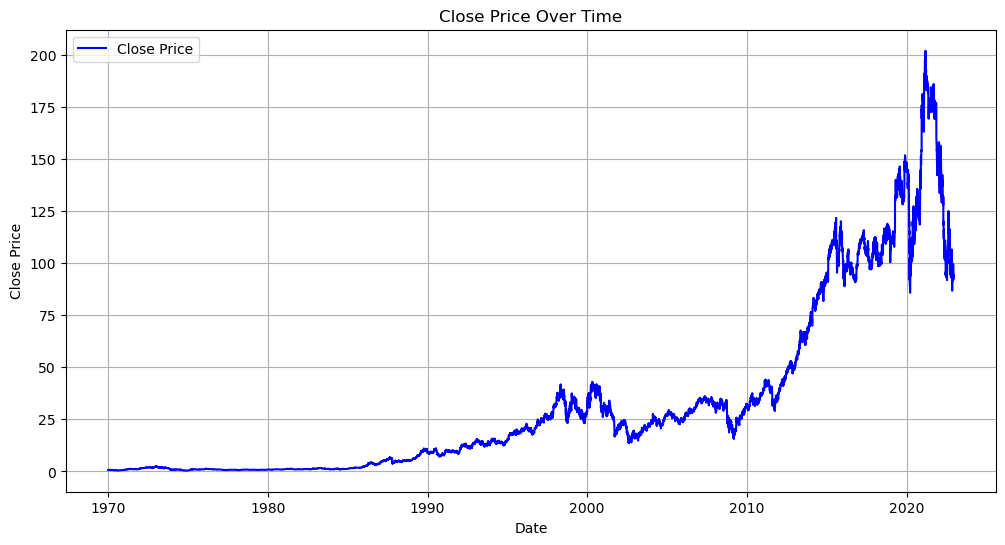

In [ ]:
# Visualizing the 'Close' prices to identify trends and anomalies
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Close'], label='Close Price', color='blue')
plt.title('Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid()
plt.show()

This line plot shows the 'Close' prices of the stock over time, highlighting a significant long-term upward trend, particularly from the 1990s to 2020, followed by a sharp decline post-2020. Noticeable spikes and drops indicate high volatility during certain periods, especially after 2010. These insights can guide preprocessing by informing sequence length selection to capture historical trends.

In real-life stock market scenarios, a 30-day sequence length is appropriate because it captures one month's worth of trading data, which is a common financial reporting period and trading cycle. Analyzing the graph, we see significant short-term fluctuations in the 'Close' price, particularly during periods of high market volatility like 2008 and post-2020. These fluctuations often represent trends or anomalies that span a few weeks to a month. By using a 30-day sequence, the model can leverage these recent trends to make more informed predictions about the next day's price while staying relevant to short-term market dynamics. Additionally, this approach aligns with real-world decision-making cycles, where investors often assess market performance over monthly periods for buy-sell decisions, making the model's predictions actionable and practical.

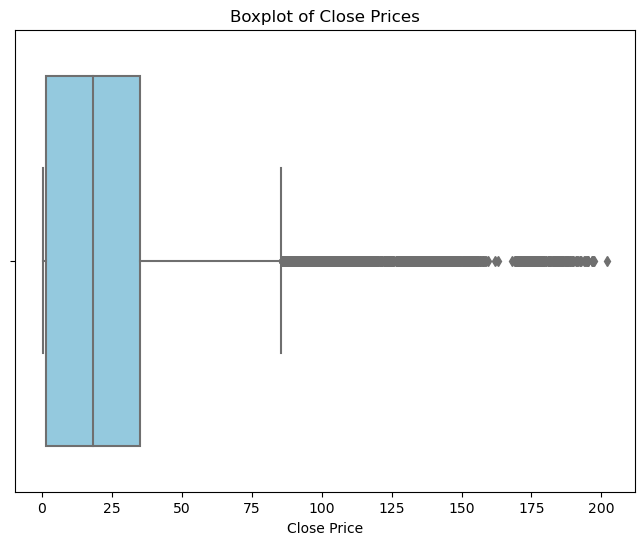

In [ ]:
# Boxplot for 'Close' prices to detect outliers
plt.figure(figsize=(8, 6))
sns.boxplot(x=data['Close'], color='skyblue')
plt.title('Boxplot of Close Prices')
plt.xlabel('Close Price')
plt.show()

The boxplot of Close prices reveals a significant number of outliers above the upper whisker, representing extreme stock price values. These outliers likely correspond to periods of heightened market activity, reflecting rapid growth, peaks, or corrections, particularly visible in recent years as seen in the trend analysis. For the stock price prediction task, these outliers indicate the need for careful handling during modeling, such as robust scaling or applying techniques like clipping or capping to prevent the model from being overly influenced by these extreme values. However, since outliers are part of real-world market conditions, they must be carefully considered rather than entirely removed, as they may contain valuable predictive information.

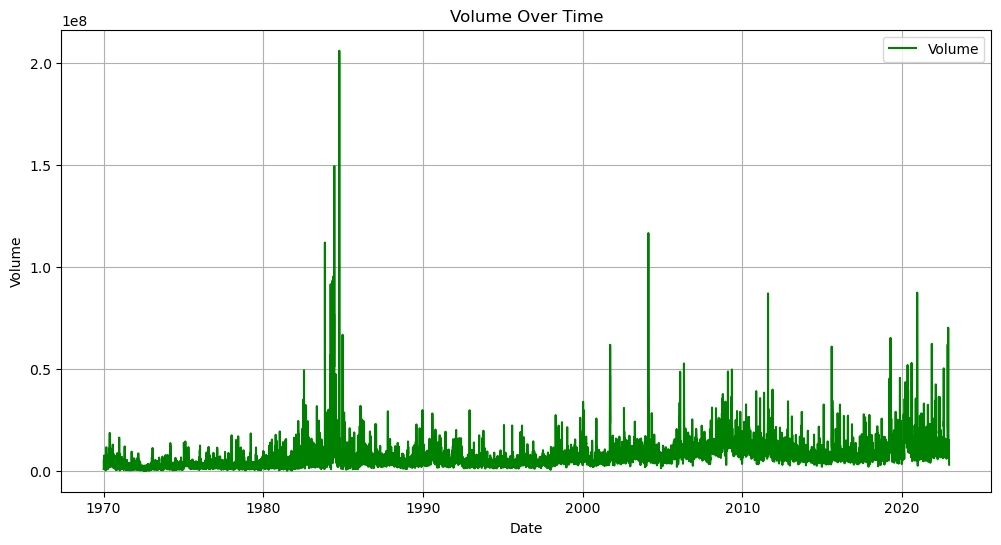

In [ ]:
# Visualizing the 'Volume' to identify unusual patterns
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Volume'], label='Volume', color='green')
plt.title('Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid()
plt.show()

The graph displays the trading volume of the stock over time, revealing key patterns and anomalies. Notable spikes in volume, particularly during the late 1980s and early 2000s, indicate periods of heightened market activity likely driven by major events, economic shifts, or company-specific news. The increasing trend in volume over the years, with periodic peaks, suggests evolving market dynamics and growing investor participation. For preprocessing, these volume spikes are important indicators of market volatility, which may correlate with significant price movements. This insight highlights the need to include volume as a feature in predictive models and to normalize or scale the data appropriately to ensure these spikes do not disproportionately influence the model while retaining their predictive significance.

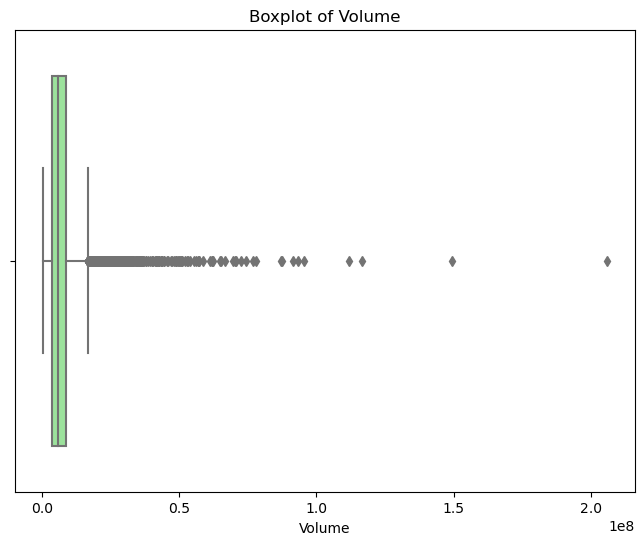

In [ ]:
# Boxplot for 'Volume' to detect outliers
plt.figure(figsize=(8, 6))
sns.boxplot(x=data['Volume'], color='lightgreen')
plt.title('Boxplot of Volume')
plt.xlabel('Volume')
plt.show()

The boxplot of Volume reveals a significant number of outliers far above the upper whisker, indicating periods of unusually high trading activity, often linked to market events or heightened investor interest. These outliers are important as they reflect potential price volatility and market anomalies. Min-Max scaling will normalize the data within a range, ensuring that these extreme values are accounted for without overwhelming the model during training. This scaling technique helps balance the influence of outliers while retaining their importance for predictive modeling, enabling the model to effectively learn from both typical and anomalous market conditions.

###  Handling Non-Consecutive Dates

In [ ]:
# Generating a full range of dates from the minimum to the maximum date
full_date_range = pd.date_range(start=data['Date'].min(), end=data['Date'].max(), freq='D')

# Identifying the missing dates
missing_dates = full_date_range.difference(data['Date'])

print("Missing dates:")
print(missing_dates)
print(f"Number of missing days: {len(missing_dates)}")

Missing dates:
DatetimeIndex(['1970-01-03', '1970-01-04', '1970-01-10', '1970-01-11',
               '1970-01-17', '1970-01-18', '1970-01-24', '1970-01-25',
               '1970-01-31', '1970-02-01',
               ...
               '2022-11-13', '2022-11-19', '2022-11-20', '2022-11-24',
               '2022-11-26', '2022-11-27', '2022-12-03', '2022-12-04',
               '2022-12-10', '2022-12-11'],
              dtype='datetime64[ns]', length=5982, freq=None)
Number of missing days: 5982


In [ ]:
# Filtering missing dates for weekends
weekend_dates = [date for date in missing_dates if date.weekday() >= 5]  # 5 = Saturday, 6 = Sunday

print("Weekend missing dates:")
print(weekend_dates)


Weekend missing dates:
[Timestamp('1970-01-03 00:00:00'), Timestamp('1970-01-04 00:00:00'), Timestamp('1970-01-10 00:00:00'), Timestamp('1970-01-11 00:00:00'), Timestamp('1970-01-17 00:00:00'), Timestamp('1970-01-18 00:00:00'), Timestamp('1970-01-24 00:00:00'), Timestamp('1970-01-25 00:00:00'), Timestamp('1970-01-31 00:00:00'), Timestamp('1970-02-01 00:00:00'), Timestamp('1970-02-07 00:00:00'), Timestamp('1970-02-08 00:00:00'), Timestamp('1970-02-14 00:00:00'), Timestamp('1970-02-15 00:00:00'), Timestamp('1970-02-21 00:00:00'), Timestamp('1970-02-22 00:00:00'), Timestamp('1970-02-28 00:00:00'), Timestamp('1970-03-01 00:00:00'), Timestamp('1970-03-07 00:00:00'), Timestamp('1970-03-08 00:00:00'), Timestamp('1970-03-14 00:00:00'), Timestamp('1970-03-15 00:00:00'), Timestamp('1970-03-21 00:00:00'), Timestamp('1970-03-22 00:00:00'), Timestamp('1970-03-28 00:00:00'), Timestamp('1970-03-29 00:00:00'), Timestamp('1970-04-04 00:00:00'), Timestamp('1970-04-05 00:00:00'), Timestamp('1970-04-11 00

In [ ]:
print(f"Number of weekend missing dates: {len(weekend_dates)}")

Number of weekend missing dates: 5526


The dataset has 5982 missing dates, most of which are weekends (5526 days), aligning with the natural gaps in stock market trading. This makes the dataset appropriate for the task, as it realistically reflects real-world market conditions without requiring additional adjustments.

### Feature Selection

In [ ]:
# Selecting relevant features
features = ['Date','Open', 'High', 'Low', 'Close', 'Volume']
target = 'Close'

# Ensuring the selected columns exist
data = data[features]
data

,Date,Open,High,Low,Close,Volume
0,1970-01-02,0.688495,0.689779,0.683357,0.683357,1109377
1,1970-01-05,0.683357,0.688495,0.662805,0.662805,1440243
2,1970-01-06,0.655098,0.655098,0.646106,0.649960,3503294
3,1970-01-07,0.652529,0.670512,0.652529,0.666658,5741510
4,1970-01-08,0.673081,0.692348,0.673081,0.683357,2316067
...,...,...,...,...,...,...
13351,2022-12-06,95.730003,96.000000,91.980003,92.290001,11492400
13352,2022-12-07,92.660004,92.790001,91.260002,92.150002,10353400
13353,2022-12-08,92.500000,93.430000,91.669998,92.550003,9351200
13354,2022-12-09,92.370003,94.910004,91.900002,93.379997,10101500


To retain only the most relevant columns for stock price prediction, I excluded the "Adjusted Close" because it is likely redundant as it mirrors the "Close" column very closely.

## Splitting the dataset



In [ ]:
# Selecting relevant features
features = ['Open', 'High', 'Low', 'Close', 'Volume']
target = 'Close'

# Splitting into features and target
X = data[features]
y = data[target]

# Train-test-validation split
train_size = int(0.7 * len(X))  # 70% for training
val_size = int(0.15 * len(X))   # 15% for validation
test_size = len(X) - train_size - val_size  # Remaining 15% for testing

X_train = X.iloc[:train_size]
y_train = y.iloc[:train_size]
X_val = X.iloc[train_size:train_size+val_size]
y_val = y.iloc[train_size:train_size+val_size]
X_test = X.iloc[train_size+val_size:]
y_test = y.iloc[train_size+val_size:]

The dataset is split into training (70%), validation (15%), and test (15%) sets sequentially to preserve the chronological order, crucial for time-series tasks. The training set, comprising the first 70% of the data, is used to train the model. The validation set is obtained as the next 15% of the data following the training set and is used to fine-tune hyperparameters and evaluate performance during training. The test set, consisting of the final 15%, assesses the model's generalization on unseen data. This approach avoids data leakage by ensuring the model doesn't use future data to inform predictions, while the proportions provide a balance between training capacity and robust evaluation.

### Feature Normalization

In [ ]:
# Applying MinMaxScaler to the training set only and transform validation and test sets using the same scaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)  # Fit and transform on the training set
X_val = scaler.transform(X_val)          # Transform validation set
X_test = scaler.transform(X_test)        # Transform test set

# Converting scaled data back to DataFrame for consistency
X_train = pd.DataFrame(X_train, columns=features)
X_val = pd.DataFrame(X_val, columns=features)
X_test = pd.DataFrame(X_test, columns=features)

Feature normalization was applied to the numeric features (Open, High, Low, Close, Volume) to scale their values to a range of [0, 1] using the MinMaxScaler. The scaler was fit on the training set only, ensuring no data leakage, and the same scaling parameters were applied to the validation and test sets. This approach ensures consistency across all datasets while preserving the integrity of the test set during evaluation. By normalizing the features, the training process becomes more stable and efficient for machine learning models like RNNs, GRUs, and LSTMs. Scaling prevents features with larger ranges (e.g., Volume) from dominating those with smaller ranges (e.g., Close), ensuring that all features contribute equally to the learning process. This step is critical for achieving accurate and reliable predictions in time-series forecasting tasks.

### Creating Sliding Window Sequences for Training

In [ ]:
# Creating sliding window sequences
sequence_length = 30
def create_sequences(X, y, sequence_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - sequence_length):
        X_seq.append(X[i:i + sequence_length].values)
        y_seq.append(y.iloc[i + sequence_length])
    return np.array(X_seq), np.array(y_seq)

X_train, y_train = create_sequences(X_train, y_train, sequence_length)
X_val, y_val = create_sequences(X_val, y_val, sequence_length)
X_test, y_test = create_sequences(X_test, y_test, sequence_length)

This part prepares the sliding window sequences for training, validation, and testing. For each data point, it collects the previous 30 days of data (sequence_length) as input features (X) and the corresponding next day's closing price as the target variable (y). The function create_sequences ensures the sequences are stored as NumPy arrays to be compatible with machine learning models.

The sequence length of 30 days is chosen because it aligns with real-world financial practices, where trends over the past month (approximately 30 trading days) are considered crucial for making predictions. This window size effectively captures short-term market behaviors, such as trends, cycles, and volatility, which are commonly observed in stock markets. It strikes a practical balance between including sufficient historical context for meaningful predictions and avoiding excessive input size that might introduce noise or computational inefficiencies. This preprocessing step ensures the data is well-structured for sequential models like RNNs, GRUs, and LSTMs.

## Model Implementation

### Evaluation metrics

In [ ]:
# Define custom RMSE metric
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))


# Function to calculate MDA (Mean Directional Accuracy)
def mda(y_true, y_pred, t=12):
    # Convert y_true and y_pred to float32 to ensure consistent data type
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    # Calculate the direction of change (sign of the difference)
    direction_true = tf.sign(y_true[1:] - y_true[:-1])  # Direction of actual values
    direction_pred = tf.sign(y_pred[1:] - y_pred[:-1])  # Direction of predicted values

    # Compare the directions and calculate the mean accuracy
    # Cast boolean output of tf.equal to float32 to avoid TypeError
    return tf.reduce_mean(tf.cast(tf.equal(direction_true, direction_pred), dtype=tf.float32))

def accuracy(y_true, y_pred, threshold=0.02):
    # Calculate Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return 100 - mape  # Return accuracy as 100 - MAPE

def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    # Calculate metrics
    acc = accuracy(y_test, y_pred)
    test_rmse = rmse(y_test, y_pred)
    test_mda = mda(y_test, y_pred)
    test_mae = mae(y_test, y_pred)

    return acc, test_rmse, test_mda, test_mae

I used RMSE, MDA, and accuracy to evaluate model performance.

RMSE: Measures the magnitude of the errors in predicted stock prices, and penalizes large deviations, which is crucial for minimizing potential financial losses due to large errors.

MDA: Measures directional prediction accuracy (whether the predicted movement direction matches the actual one).
This is key in trading, where predicting the right trend (up or down) is more important than predicting the exact value.

Accuracy: Used for directional prediction. It measures how often the model correctly predicts whether the stock price will go up or down, which is an essential part of trend-based trading strategies.

MAE (Mean Absolute Error): Measures the average magnitude of errors in predictions without considering their direction. Unlike RMSE, it treats all errors equally, regardless of whether they are large or small, making it a simpler measure to understand the general performance of the model. MAE provides a straightforward metric for evaluating how close the model's predictions are to the actual values in terms of absolute difference.

Together, RMSE, MDA, Accuracy, and MAE provide a well-rounded evaluation of the models' performance. These metrics capture both magnitude (how close the predicted prices are) and direction (whether the model predicts the correct price trend), allowing for a comprehensive assessment of model accuracy, reliability, and practical utility in stock market prediction.

## Model Architectures

### Vanilla RNN (Baseline Model)

In [ ]:
def build_simple_rnn(input_shape, rnn_units, dropout_rate, learning_rate):
    model = Sequential()
    model.add(SimpleRNN(rnn_units, return_sequences=True, input_shape=input_shape, activation='tanh'))  # tanh activation
    model.add(Dropout(dropout_rate))
    model.add(SimpleRNN(rnn_units, activation='tanh'))  # Stacked RNN layer with tanh
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))  # Output layer
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=[rmse, mda, 'mae'])
    return model

### GRU

In [ ]:
def build_gru(input_shape, rnn_units, dropout_rate, learning_rate):
    model = Sequential()
    model.add(GRU(rnn_units, return_sequences=True, input_shape=input_shape, activation='tanh'))  # tanh activation
    model.add(Dropout(dropout_rate))
    model.add(GRU(rnn_units, activation='tanh'))  # Stacked GRU layer with tanh
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))  # Output layer
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=[rmse, mda, 'mae'])
    return model

### LSTM

In [ ]:
def build_lstm(input_shape, rnn_units, dropout_rate, learning_rate):
    model = Sequential()
    model.add(LSTM(rnn_units, return_sequences=True, input_shape=input_shape, activation='tanh'))  # tanh activation
    model.add(Dropout(dropout_rate))
    model.add(LSTM(rnn_units, activation='tanh'))  # Stacked LSTM layer with tanh
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))  # Output layer
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=[rmse, mda, 'mae'])
    return model

I built 3 types of models: SimpleRNN, GRU, and LSTM. These are all variants of recurrent neural networks (RNNs) designed to process sequential data. The architectures are composed of several layers: the first layer in each model is a recurrent layer (SimpleRNN, GRU, or LSTM), with the return_sequences=True argument ensuring that the output of each timestep is passed on to the next layer, enabling the model to capture temporal dependencies effectively. A second stacked recurrent layer further enhances the model's ability to learn hierarchical temporal patterns, making it better suited for complex sequential relationships. Each recurrent layer uses the tanh activation function, which scales outputs to the range [-1, 1], stabilizing gradients during training and enabling smooth learning. Dropout layers are applied after each recurrent layer to prevent overfitting by randomly setting a fraction of the input units to 0 during training. Finally, the Dense output layer, with a linear activation function, predicts the closing price. This architecture is particularly suitable for time-series forecasting tasks, such as stock price prediction, as it effectively captures both short-term and long-term temporal patterns in sequential data.

### Hyper-parameter Tuning and Training of each model on best parameters

In [ ]:
def get_callbacks():
    callbacks = [
        ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1),  # Updated file extension
        EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
    ]
    return callbacks


In [ ]:
# Hyperparameter tuning function with logging
def tune_model(build_model_fn, X_train, y_train, X_val, y_val, param_grid):
    best_model = None
    best_val_loss = float('inf')
    best_params = None
    results = []  # Log results

    for params in ParameterGrid(param_grid):
        print(f"Training with parameters: {params}")
        print("-" * 100)  # Add dashed line before training starts

        # Extract parameters for the model
        model_params = {k: params[k] for k in ['rnn_units', 'dropout_rate', 'learning_rate']}
        batch_size = params['batch_size']

        # Build the model
        model = build_model_fn(input_shape=(X_train.shape[1], X_train.shape[2]), **model_params)

        # Train the model
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=50,
            batch_size=batch_size,
            callbacks=get_callbacks(),
            verbose=1
        )

        # Get validation loss and metrics from history
        val_loss = min(history.history['val_loss'])
        val_rmse = min(history.history['val_rmse'])
        val_mda = max(history.history['val_mda'])
        val_mae = min(history.history['val_mae'])

        # Log results with 2 decimal precision
        results.append({**params,
                        'val_loss': f"{val_loss:.5f}",
                        'val_rmse': f"{val_rmse:.5f}",
                        'val_mda': f"{val_mda:.5f}",
                        'val_mae': f"{val_mae:.5f}"})

        # Print out results with 2 decimal precision
        print(f"Validation Loss: {val_loss:.5f}, RMSE: {val_rmse:.5f}, MDA: {val_mda:.5f}, MAE: {val_mae:.5f}")
        print("-" * 50)

        # Update the best model if validation loss improves
        if val_loss < best_val_loss:
            best_model = model
            best_val_loss = val_loss
            best_params = params

    results_df = pd.DataFrame(results)
    return best_model, best_params, best_val_loss, results_df

### Hyper-parameter Grid

In [ ]:
# Defining hyperparameter search space
param_grid = {
    'rnn_units': [32, 64, 128],
    'dropout_rate': [0.2, 0.3],
    'learning_rate': [0.001, 0.01],
    'batch_size': [16, 32]
}


### Tuning Vanilla RNN

In [ ]:
# Tuning the models
print("Tuning SimpleRNN...")
best_rnn_model, best_rnn_params, best_rnn_loss, rnn_results = tune_model(build_simple_rnn, X_train, y_train, X_val, y_val, param_grid)
print(f"Best SimpleRNN Parameters: {best_rnn_params}, Validation Loss: {best_rnn_loss}")


Tuning SimpleRNN...
Training with parameters: {'batch_size': 16, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'rnn_units': 32}
----------------------------------------------------------------------------------------------------
Epoch 1/50


/Users/sadafahmedsara/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


568/583 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0170 - mae: 0.0736 - mda: 0.4994 - rmse: 0.1304
Epoch 1: val_loss improved from inf to 0.00156, saving model to best_model.keras
583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0167 - mae: 0.0728 - mda: 0.4994 - rmse: 0.1295 - val_loss: 0.0016 - val_mae: 0.0296 - val_mda: 0.5007 - val_rmse: 0.0312 - learning_rate: 0.0010
Epoch 2/50
565/583 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.8983e-04 - mae: 0.0184 - mda: 0.5038 - rmse: 0.0800
Epoch 2: val_loss improved from 0.00156 to 0.00047, saving model to best_model.keras
583/583 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.8440e-04 - mae: 0.0184 - mda: 0.5039 - rmse: 0.0800 - val_loss: 4.6543e-04 - val_mae: 0.0141 - val_mda: 0.4995 - val_rmse: 0.0157 - learning_rate: 0.0010
Epoch 3/50
556/583 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.6130e-04 - mae: 0.0126 - mda: 0.5053 - rmse: 0.0765
Epoch 3: val_loss improved from 0.00047 to 0.00030, saving model to best_model.keras
583/583 ━━━━━━━━━━━━

560/583 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.4281e-05 - mae: 0.0048 - mda: 0.5068 - rmse: 0.0767
Epoch 19: val_loss did not improve from 0.00004
583/583 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.4307e-05 - mae: 0.0048 - mda: 0.5068 - rmse: 0.0767 - val_loss: 6.5632e-05 - val_mae: 0.0051 - val_mda: 0.5207 - val_rmse: 0.0078 - learning_rate: 5.0000e-04
Epoch 20/50
561/583 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.9862e-05 - mae: 0.0051 - mda: 0.5086 - rmse: 0.0774
Epoch 20: val_loss did not improve from 0.00004

Epoch 20: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
583/583 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.9725e-05 - mae: 0.0051 - mda: 0.5086 - rmse: 0.0774 - val_loss: 5.5917e-04 - val_mae: 0.0191 - val_mda: 0.5208 - val_rmse: 0.0203 - learning_rate: 5.0000e-04
Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 10.
Validation Loss: 0.00004, RMSE: 0.00715, MDA: 0.52076, MAE: 0.00436
-------------------------------------

Epoch 16/50
569/583 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.3446e-05 - mae: 0.0042 - mda: 0.5091 - rmse: 0.0767
Epoch 16: val_loss did not improve from 0.00003
583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 3.3441e-05 - mae: 0.0042 - mda: 0.5091 - rmse: 0.0767 - val_loss: 5.8225e-05 - val_mae: 0.0058 - val_mda: 0.5161 - val_rmse: 0.0083 - learning_rate: 2.5000e-04
Epoch 17/50
565/583 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.4127e-05 - mae: 0.0042 - mda: 0.5089 - rmse: 0.0776
Epoch 17: val_loss did not improve from 0.00003
583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 3.4112e-05 - mae: 0.0042 - mda: 0.5088 - rmse: 0.0775 - val_loss: 2.6646e-05 - val_mae: 0.0041 - val_mda: 0.5151 - val_rmse: 0.0069 - learning_rate: 2.5000e-04
Epoch 18/50
582/583 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.3249e-05 - mae: 0.0041 - mda: 0.5083 - rmse: 0.0764
Epoch 18: val_loss improved from 0.00003 to 0.00002, saving model to best_model.keras
583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 3.3247

Epoch 34/50
568/583 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1611e-05 - mae: 0.0033 - mda: 0.5078 - rmse: 0.0762
Epoch 34: val_loss did not improve from 0.00002
583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2.1638e-05 - mae: 0.0033 - mda: 0.5077 - rmse: 0.0762 - val_loss: 3.0807e-05 - val_mae: 0.0038 - val_mda: 0.5191 - val_rmse: 0.0068 - learning_rate: 3.1250e-05
Epoch 35/50
568/583 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1465e-05 - mae: 0.0033 - mda: 0.5077 - rmse: 0.0763
Epoch 35: val_loss did not improve from 0.00002

Epoch 35: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2.1472e-05 - mae: 0.0033 - mda: 0.5077 - rmse: 0.0763 - val_loss: 5.0587e-05 - val_mae: 0.0050 - val_mda: 0.5205 - val_rmse: 0.0077 - learning_rate: 3.1250e-05
Epoch 36/50
568/583 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2717e-05 - mae: 0.0033 - mda: 0.5077 - rmse: 0.0771
Epoch 36: val_loss did not improve from 0.00002
583/583 ━━━━━━

576/583 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.9761e-05 - mae: 0.0045 - mda: 0.5073 - rmse: 0.0765
Epoch 12: val_loss did not improve from 0.00002

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 3.9778e-05 - mae: 0.0045 - mda: 0.5073 - rmse: 0.0765 - val_loss: 3.9643e-05 - val_mae: 0.0053 - val_mda: 0.5132 - val_rmse: 0.0082 - learning_rate: 5.0000e-04
Epoch 13/50
577/583 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.3114e-05 - mae: 0.0041 - mda: 0.5076 - rmse: 0.0766
Epoch 13: val_loss did not improve from 0.00002
583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 3.3107e-05 - mae: 0.0041 - mda: 0.5076 - rmse: 0.0766 - val_loss: 2.1130e-05 - val_mae: 0.0034 - val_mda: 0.5169 - val_rmse: 0.0066 - learning_rate: 2.5000e-04
Epoch 14/50
577/583 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.0415e-05 - mae: 0.0038 - mda: 0.5088 - rmse: 0.0775
Epoch 14: val_loss did not improve from 0.00002
583/583 ━━━━━━━━━━━━━━━━━━━

559/583 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.0389e-05 - mae: 0.0058 - mda: 0.5082 - rmse: 0.0770
Epoch 10: val_loss did not improve from 0.00013
583/583 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.0275e-05 - mae: 0.0057 - mda: 0.5082 - rmse: 0.0770 - val_loss: 2.5792e-04 - val_mae: 0.0097 - val_mda: 0.5180 - val_rmse: 0.0119 - learning_rate: 0.0050
Epoch 11/50
558/583 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.1736e-05 - mae: 0.0058 - mda: 0.5070 - rmse: 0.0779
Epoch 11: val_loss did not improve from 0.00013

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
583/583 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.1631e-05 - mae: 0.0058 - mda: 0.5070 - rmse: 0.0778 - val_loss: 5.9870e-04 - val_mae: 0.0187 - val_mda: 0.5178 - val_rmse: 0.0200 - learning_rate: 0.0050
Epoch 12/50
560/583 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.5672e-05 - mae: 0.0054 - mda: 0.5058 - rmse: 0.0765
Epoch 12: val_loss did not improve from 0.00013
583/583 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms

566/583 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3596e-04 - mae: 0.0089 - mda: 0.5062 - rmse: 0.0757
Epoch 9: val_loss did not improve from 0.00419
583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.3582e-04 - mae: 0.0089 - mda: 0.5062 - rmse: 0.0757 - val_loss: 0.0057 - val_mae: 0.0467 - val_mda: 0.5151 - val_rmse: 0.0477 - learning_rate: 0.0100
Epoch 10/50
566/583 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2152e-04 - mae: 0.0083 - mda: 0.5077 - rmse: 0.0764
Epoch 10: val_loss improved from 0.00419 to 0.00209, saving model to best_model.keras
583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.2132e-04 - mae: 0.0083 - mda: 0.5077 - rmse: 0.0764 - val_loss: 0.0021 - val_mae: 0.0245 - val_mda: 0.5209 - val_rmse: 0.0261 - learning_rate: 0.0100
Epoch 11/50
567/583 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.4685e-05 - mae: 0.0064 - mda: 0.5061 - rmse: 0.0769
Epoch 11: val_loss did not improve from 0.00209
583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 7.4648e-05 - mae: 0.0064 - mda: 0.5

566/583 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0048 - mae: 0.0566 - mda: 0.4998 - rmse: 0.0677
Epoch 27: val_loss did not improve from 0.00002

Epoch 27: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0048 - mae: 0.0566 - mda: 0.4998 - rmse: 0.0677 - val_loss: 0.0371 - val_mae: 0.1667 - val_mda: 0.4962 - val_rmse: 0.1671 - learning_rate: 0.0050
Epoch 28/50
568/583 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0038 - mae: 0.0519 - mda: 0.4988 - rmse: 0.0612
Epoch 28: val_loss did not improve from 0.00002
583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0038 - mae: 0.0519 - mda: 0.4989 - rmse: 0.0612 - val_loss: 0.0417 - val_mae: 0.1827 - val_mda: 0.5093 - val_rmse: 0.1830 - learning_rate: 0.0025
Epoch 29/50
567/583 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0020 - mae: 0.0341 - mda: 0.5023 - rmse: 0.0693
Epoch 29: val_loss did not improve from 0.00002
583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0020 - mae: 

Epoch 13/50
582/583 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011 - mae: 0.0262 - mda: 0.5049 - rmse: 0.0812
Epoch 13: val_loss did not improve from 0.00794
583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0011 - mae: 0.0262 - mda: 0.5049 - rmse: 0.0812 - val_loss: 0.0522 - val_mae: 0.1530 - val_mda: 0.4744 - val_rmse: 0.1536 - learning_rate: 0.0100
Epoch 14/50
576/583 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0239 - mae: 0.1178 - mda: 0.5012 - rmse: 0.1359
Epoch 14: val_loss did not improve from 0.00794

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0238 - mae: 0.1175 - mda: 0.5012 - rmse: 0.1355 - val_loss: 0.0363 - val_mae: 0.1657 - val_mda: 0.5142 - val_rmse: 0.1660 - learning_rate: 0.0100
Epoch 15/50
576/583 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0021 - mae: 0.0349 - mda: 0.5017 - rmse: 0.0755
Epoch 15: val_loss did not improve from 0.00794
583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0

558/583 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.9700e-05 - mae: 0.0069 - mda: 0.5062 - rmse: 0.0771
Epoch 11: val_loss did not improve from 0.00013
583/583 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.9761e-05 - mae: 0.0069 - mda: 0.5062 - rmse: 0.0771 - val_loss: 5.1041e-04 - val_mae: 0.0149 - val_mda: 0.5179 - val_rmse: 0.0164 - learning_rate: 5.0000e-04
Epoch 12/50
568/583 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.5298e-05 - mae: 0.0067 - mda: 0.5084 - rmse: 0.0766
Epoch 12: val_loss did not improve from 0.00013

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
583/583 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.5349e-05 - mae: 0.0067 - mda: 0.5084 - rmse: 0.0766 - val_loss: 2.8811e-04 - val_mae: 0.0102 - val_mda: 0.5183 - val_rmse: 0.0119 - learning_rate: 5.0000e-04
Epoch 13/50
573/583 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.8919e-05 - mae: 0.0063 - mda: 0.5077 - rmse: 0.0762
Epoch 13: val_loss did not improve from 0.00013
583/583 ━━━━━━━━━━━━━━━━━━━

Epoch 10/50
573/583 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.2011e-05 - mae: 0.0056 - mda: 0.5082 - rmse: 0.0762
Epoch 10: val_loss improved from 0.00005 to 0.00004, saving model to best_model.keras
583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 6.1987e-05 - mae: 0.0056 - mda: 0.5082 - rmse: 0.0762 - val_loss: 4.1708e-05 - val_mae: 0.0046 - val_mda: 0.5178 - val_rmse: 0.0071 - learning_rate: 5.0000e-04
Epoch 11/50
579/583 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.7775e-05 - mae: 0.0054 - mda: 0.5083 - rmse: 0.0767
Epoch 11: val_loss did not improve from 0.00004
583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 5.7767e-05 - mae: 0.0054 - mda: 0.5083 - rmse: 0.0767 - val_loss: 1.6691e-04 - val_mae: 0.0091 - val_mda: 0.5152 - val_rmse: 0.0110 - learning_rate: 5.0000e-04
Epoch 12/50
577/583 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.7880e-05 - mae: 0.0054 - mda: 0.5084 - rmse: 0.0779
Epoch 12: val_loss did not improve from 0.00004
583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 5.7845

576/583 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.2230e-05 - mae: 0.0067 - mda: 0.5079 - rmse: 0.0772
Epoch 7: val_loss did not improve from 0.00003

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 9.2109e-05 - mae: 0.0067 - mda: 0.5079 - rmse: 0.0772 - val_loss: 1.5780e-04 - val_mae: 0.0105 - val_mda: 0.5099 - val_rmse: 0.0123 - learning_rate: 0.0010
Epoch 8/50
575/583 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.5866e-05 - mae: 0.0058 - mda: 0.5060 - rmse: 0.0777
Epoch 8: val_loss improved from 0.00003 to 0.00002, saving model to best_model.keras
583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 6.5825e-05 - mae: 0.0058 - mda: 0.5060 - rmse: 0.0777 - val_loss: 2.4753e-05 - val_mae: 0.0037 - val_mda: 0.5128 - val_rmse: 0.0064 - learning_rate: 5.0000e-04
Epoch 9/50
574/583 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.0163e-05 - mae: 0.0053 - mda: 0.5076 - rmse: 0.0763
Epoch 9: val_loss improved from 0.00002 to 0.0

Epoch 25/50
576/583 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.1971e-05 - mae: 0.0033 - mda: 0.5070 - rmse: 0.0760
Epoch 25: val_loss did not improve from 0.00002
583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.1991e-05 - mae: 0.0033 - mda: 0.5070 - rmse: 0.0760 - val_loss: 4.2053e-05 - val_mae: 0.0047 - val_mda: 0.5220 - val_rmse: 0.0073 - learning_rate: 6.2500e-05
Epoch 26/50
579/583 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.3383e-05 - mae: 0.0034 - mda: 0.5084 - rmse: 0.0757
Epoch 26: val_loss did not improve from 0.00002
583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.3382e-05 - mae: 0.0034 - mda: 0.5084 - rmse: 0.0757 - val_loss: 2.1956e-05 - val_mae: 0.0034 - val_mda: 0.5224 - val_rmse: 0.0063 - learning_rate: 6.2500e-05
Epoch 27/50
577/583 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.3377e-05 - mae: 0.0034 - mda: 0.5087 - rmse: 0.0764
Epoch 27: val_loss did not improve from 0.00002

Epoch 27: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
583/583 ━━━━━━━

581/583 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.0146e-05 - mae: 0.0069 - mda: 0.5069 - rmse: 0.0769
Epoch 10: val_loss did not improve from 0.00018
583/583 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.0141e-05 - mae: 0.0069 - mda: 0.5069 - rmse: 0.0769 - val_loss: 5.9371e-04 - val_mae: 0.0132 - val_mda: 0.5172 - val_rmse: 0.0154 - learning_rate: 0.0050
Epoch 11/50
564/583 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0016e-04 - mae: 0.0073 - mda: 0.5079 - rmse: 0.0771
Epoch 11: val_loss did not improve from 0.00018
583/583 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0020e-04 - mae: 0.0073 - mda: 0.5079 - rmse: 0.0771 - val_loss: 9.1037e-04 - val_mae: 0.0195 - val_mda: 0.5184 - val_rmse: 0.0210 - learning_rate: 0.0050
Epoch 12/50
580/583 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.5354e-05 - mae: 0.0071 - mda: 0.5060 - rmse: 0.0761
Epoch 12: val_loss did not improve from 0.00018

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
583/583 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms

572/583 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6380 - mae: 0.4528 - mda: 0.5003 - rmse: 0.5391
Epoch 1: val_loss improved from inf to 0.01347, saving model to best_model.keras
583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.6286 - mae: 0.4472 - mda: 0.5003 - rmse: 0.5330 - val_loss: 0.0135 - val_mae: 0.0831 - val_mda: 0.4997 - val_rmse: 0.0836 - learning_rate: 0.0100
Epoch 2/50
574/583 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.3768e-04 - mae: 0.0180 - mda: 0.5020 - rmse: 0.0754
Epoch 2: val_loss improved from 0.01347 to 0.01313, saving model to best_model.keras
583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 5.3777e-04 - mae: 0.0180 - mda: 0.5020 - rmse: 0.0754 - val_loss: 0.0131 - val_mae: 0.0753 - val_mda: 0.5013 - val_rmse: 0.0759 - learning_rate: 0.0100
Epoch 3/50
579/583 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.0901e-04 - mae: 0.0176 - mda: 0.5034 - rmse: 0.0763
Epoch 3: val_loss improved from 0.01313 to 0.01240, saving model to best_model.keras
583/583 ━━━━━━━━━━━━━━━━

292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.7385e-04 - mae: 0.0197 - mda: 0.5005 - rmse: 0.0823 - val_loss: 3.6135e-04 - val_mae: 0.0128 - val_mda: 0.4978 - val_rmse: 0.0166 - learning_rate: 0.0010
Epoch 4/50
275/292 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.5922e-04 - mae: 0.0156 - mda: 0.5012 - rmse: 0.0800
Epoch 4: val_loss did not improve from 0.00036
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.5577e-04 - mae: 0.0155 - mda: 0.5013 - rmse: 0.0801 - val_loss: 4.4022e-04 - val_mae: 0.0146 - val_mda: 0.4987 - val_rmse: 0.0181 - learning_rate: 0.0010
Epoch 5/50
280/292 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.0287e-04 - mae: 0.0134 - mda: 0.5020 - rmse: 0.0803
Epoch 5: val_loss improved from 0.00036 to 0.00024, saving model to best_model.keras
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.0169e-04 - mae: 0.0133 - mda: 0.5020 - rmse: 0.0803 - val_loss: 2.4147e-04 - val_mae: 0.0099 - val_mda: 0.4993 - val_rmse: 0.0139 - learning_rate: 0.0010
Epoch 6/50
279/292 ━━━━━━

292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.9999e-05 - mae: 0.0061 - mda: 0.5026 - rmse: 0.0787 - val_loss: 1.7269e-04 - val_mae: 0.0091 - val_mda: 0.5071 - val_rmse: 0.0130 - learning_rate: 2.5000e-04
Epoch 22/50
286/292 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.5021e-05 - mae: 0.0060 - mda: 0.5029 - rmse: 0.0788
Epoch 22: val_loss did not improve from 0.00008
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.5062e-05 - mae: 0.0060 - mda: 0.5029 - rmse: 0.0788 - val_loss: 1.4080e-04 - val_mae: 0.0079 - val_mda: 0.5079 - val_rmse: 0.0120 - learning_rate: 1.2500e-04
Epoch 23/50
282/292 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.8502e-05 - mae: 0.0062 - mda: 0.5036 - rmse: 0.0786
Epoch 23: val_loss did not improve from 0.00008
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.8420e-05 - mae: 0.0062 - mda: 0.5036 - rmse: 0.0786 - val_loss: 9.0755e-05 - val_mae: 0.0063 - val_mda: 0.5077 - val_rmse: 0.0107 - learning_rate: 1.2500e-04
Epoch 24/50
286/292 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms

Epoch 13/50
286/292 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.2837e-05 - mae: 0.0065 - mda: 0.5026 - rmse: 0.0789
Epoch 13: val_loss did not improve from 0.00011

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.2842e-05 - mae: 0.0065 - mda: 0.5026 - rmse: 0.0789 - val_loss: 1.0934e-04 - val_mae: 0.0070 - val_mda: 0.5025 - val_rmse: 0.0110 - learning_rate: 5.0000e-04
Epoch 14/50
286/292 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.1236e-05 - mae: 0.0064 - mda: 0.5028 - rmse: 0.0781
Epoch 14: val_loss improved from 0.00011 to 0.00007, saving model to best_model.keras
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.1242e-05 - mae: 0.0064 - mda: 0.5028 - rmse: 0.0781 - val_loss: 7.2416e-05 - val_mae: 0.0057 - val_mda: 0.5031 - val_rmse: 0.0101 - learning_rate: 2.5000e-04
Epoch 15/50
286/292 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.5099e-05 - mae: 0.0061 - mda: 0.5022 - rmse: 0.0790
Epoch 15: val_loss did no

Epoch 31/50
288/292 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.8446e-05 - mae: 0.0048 - mda: 0.5031 - rmse: 0.0785
Epoch 31: val_loss did not improve from 0.00005
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.8431e-05 - mae: 0.0048 - mda: 0.5031 - rmse: 0.0785 - val_loss: 6.9269e-05 - val_mae: 0.0057 - val_mda: 0.5069 - val_rmse: 0.0101 - learning_rate: 3.1250e-05
Epoch 32/50
288/292 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.6841e-05 - mae: 0.0047 - mda: 0.5036 - rmse: 0.0780
Epoch 32: val_loss did not improve from 0.00005
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.6859e-05 - mae: 0.0047 - mda: 0.5036 - rmse: 0.0780 - val_loss: 6.6073e-05 - val_mae: 0.0055 - val_mda: 0.5071 - val_rmse: 0.0100 - learning_rate: 3.1250e-05
Epoch 33/50
289/292 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.8450e-05 - mae: 0.0048 - mda: 0.5034 - rmse: 0.0785
Epoch 33: val_loss did not improve from 0.00005
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.8454e-05 - mae: 0.0048 - mda: 0.5034 - rms

Epoch 9/50
289/292 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.1475e-05 - mae: 0.0065 - mda: 0.5036 - rmse: 0.0785
Epoch 9: val_loss did not improve from 0.00004
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 9.1379e-05 - mae: 0.0065 - mda: 0.5036 - rmse: 0.0785 - val_loss: 7.4198e-05 - val_mae: 0.0066 - val_mda: 0.5001 - val_rmse: 0.0109 - learning_rate: 5.0000e-04
Epoch 10/50
288/292 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.4682e-05 - mae: 0.0061 - mda: 0.5030 - rmse: 0.0789
Epoch 10: val_loss improved from 0.00004 to 0.00003, saving model to best_model.keras
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 7.4681e-05 - mae: 0.0060 - mda: 0.5030 - rmse: 0.0789 - val_loss: 2.7822e-05 - val_mae: 0.0039 - val_mda: 0.5029 - val_rmse: 0.0090 - learning_rate: 5.0000e-04
Epoch 11/50
289/292 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.3652e-05 - mae: 0.0059 - mda: 0.5028 - rmse: 0.0787
Epoch 11: val_loss did not improve from 0.00003
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 7.3675e-

Epoch 27/50
285/292 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.8012e-05 - mae: 0.0043 - mda: 0.5039 - rmse: 0.0798
Epoch 27: val_loss did not improve from 0.00002
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 3.8006e-05 - mae: 0.0043 - mda: 0.5039 - rmse: 0.0797 - val_loss: 1.9369e-05 - val_mae: 0.0032 - val_mda: 0.5048 - val_rmse: 0.0087 - learning_rate: 6.2500e-05
Epoch 28/50
289/292 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.7442e-05 - mae: 0.0042 - mda: 0.5031 - rmse: 0.0784
Epoch 28: val_loss did not improve from 0.00002

Epoch 28: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 3.7437e-05 - mae: 0.0042 - mda: 0.5031 - rmse: 0.0784 - val_loss: 2.6883e-05 - val_mae: 0.0039 - val_mda: 0.5054 - val_rmse: 0.0092 - learning_rate: 6.2500e-05
Epoch 29/50
289/292 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.5839e-05 - mae: 0.0041 - mda: 0.5045 - rmse: 0.0784
Epoch 29: val_loss did not improve from 0.00002
292/292 ━━━━━━━

Epoch 9/50
276/292 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.6880e-05 - mae: 0.0059 - mda: 0.5042 - rmse: 0.0785
Epoch 9: val_loss did not improve from 0.00024
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.6795e-05 - mae: 0.0059 - mda: 0.5042 - rmse: 0.0785 - val_loss: 4.4874e-04 - val_mae: 0.0141 - val_mda: 0.5036 - val_rmse: 0.0174 - learning_rate: 0.0050
Epoch 10/50
286/292 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.1404e-05 - mae: 0.0056 - mda: 0.5035 - rmse: 0.0790
Epoch 10: val_loss did not improve from 0.00024
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.1408e-05 - mae: 0.0056 - mda: 0.5035 - rmse: 0.0790 - val_loss: 8.1020e-04 - val_mae: 0.0202 - val_mda: 0.5029 - val_rmse: 0.0229 - learning_rate: 0.0050
Epoch 11/50
286/292 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.2211e-05 - mae: 0.0056 - mda: 0.5037 - rmse: 0.0779
Epoch 11: val_loss did not improve from 0.00024
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.2201e-05 - mae: 0.0056 - mda: 0.5037 - rmse: 0.0779 

Epoch 11/50
286/292 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.6833e-04 - mae: 0.0128 - mda: 0.5020 - rmse: 0.0778
Epoch 11: val_loss improved from 0.01177 to 0.01085, saving model to best_model.keras
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.6835e-04 - mae: 0.0128 - mda: 0.5020 - rmse: 0.0778 - val_loss: 0.0108 - val_mae: 0.0599 - val_mda: 0.5032 - val_rmse: 0.0629 - learning_rate: 0.0100
Epoch 12/50
286/292 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.5831e-04 - mae: 0.0126 - mda: 0.5027 - rmse: 0.0781
Epoch 12: val_loss did not improve from 0.01085
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.5872e-04 - mae: 0.0126 - mda: 0.5027 - rmse: 0.0781 - val_loss: 0.0132 - val_mae: 0.0725 - val_mda: 0.5037 - val_rmse: 0.0753 - learning_rate: 0.0100
Epoch 13/50
284/292 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.6276e-04 - mae: 0.0127 - mda: 0.5021 - rmse: 0.0779
Epoch 13: val_loss did not improve from 0.01085
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.6292e-04 - mae: 0.01

292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0041 - mae: 0.0530 - mda: 0.5001 - rmse: 0.0627 - val_loss: 0.0253 - val_mae: 0.1235 - val_mda: 0.4991 - val_rmse: 0.1261 - learning_rate: 0.0100
Epoch 5/50
288/292 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0045 - mae: 0.0555 - mda: 0.4998 - rmse: 0.0664
Epoch 5: val_loss did not improve from 0.02533
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0045 - mae: 0.0556 - mda: 0.4998 - rmse: 0.0665 - val_loss: 0.0698 - val_mae: 0.2435 - val_mda: 0.5047 - val_rmse: 0.2457 - learning_rate: 0.0100
Epoch 6/50
289/292 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0063 - mae: 0.0644 - mda: 0.5006 - rmse: 0.0769
Epoch 6: val_loss improved from 0.02533 to 0.02394, saving model to best_model.keras
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0063 - mae: 0.0643 - mda: 0.5006 - rmse: 0.0768 - val_loss: 0.0239 - val_mae: 0.1188 - val_mda: 0.5065 - val_rmse: 0.1213 - learning_rate: 0.0100
Epoch 7/50
289/292 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - los

Epoch 23/50
287/292 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.3802e-04 - mae: 0.0123 - mda: 0.5031 - rmse: 0.0773
Epoch 23: val_loss improved from 0.00872 to 0.00840, saving model to best_model.keras
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 2.3765e-04 - mae: 0.0123 - mda: 0.5031 - rmse: 0.0773 - val_loss: 0.0084 - val_mae: 0.0596 - val_mda: 0.5090 - val_rmse: 0.0621 - learning_rate: 0.0025
Epoch 24/50
289/292 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.2127e-04 - mae: 0.0117 - mda: 0.5018 - rmse: 0.0785
Epoch 24: val_loss did not improve from 0.00840
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 2.2159e-04 - mae: 0.0117 - mda: 0.5018 - rmse: 0.0785 - val_loss: 0.0103 - val_mae: 0.0585 - val_mda: 0.5104 - val_rmse: 0.0619 - learning_rate: 0.0025
Epoch 25/50
289/292 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.0018e-04 - mae: 0.0139 - mda: 0.5027 - rmse: 0.0787
Epoch 25: val_loss improved from 0.00840 to 0.00778, saving model to best_model.keras
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 7

285/292 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.1792e-04 - mae: 0.0142 - mda: 0.5015 - rmse: 0.0793
Epoch 5: val_loss improved from 0.00074 to 0.00063, saving model to best_model.keras
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.1745e-04 - mae: 0.0142 - mda: 0.5015 - rmse: 0.0793 - val_loss: 6.2915e-04 - val_mae: 0.0162 - val_mda: 0.4986 - val_rmse: 0.0193 - learning_rate: 0.0010
Epoch 6/50
286/292 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5172e-04 - mae: 0.0129 - mda: 0.5030 - rmse: 0.0788
Epoch 6: val_loss improved from 0.00063 to 0.00047, saving model to best_model.keras
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.5134e-04 - mae: 0.0129 - mda: 0.5030 - rmse: 0.0788 - val_loss: 4.7121e-04 - val_mae: 0.0139 - val_mda: 0.5000 - val_rmse: 0.0171 - learning_rate: 0.0010
Epoch 7/50
285/292 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1323e-04 - mae: 0.0118 - mda: 0.5023 - rmse: 0.0798
Epoch 7: val_loss improved from 0.00047 to 0.00041, saving model to best_model.keras
292/

285/292 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.7656e-05 - mae: 0.0063 - mda: 0.5027 - rmse: 0.0788
Epoch 23: val_loss did not improve from 0.00009
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.7608e-05 - mae: 0.0063 - mda: 0.5027 - rmse: 0.0788 - val_loss: 2.7240e-04 - val_mae: 0.0107 - val_mda: 0.5079 - val_rmse: 0.0144 - learning_rate: 5.0000e-04
Epoch 24/50
286/292 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.2379e-05 - mae: 0.0061 - mda: 0.5036 - rmse: 0.0774
Epoch 24: val_loss did not improve from 0.00009
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.2394e-05 - mae: 0.0061 - mda: 0.5036 - rmse: 0.0774 - val_loss: 2.4275e-04 - val_mae: 0.0097 - val_mda: 0.5075 - val_rmse: 0.0135 - learning_rate: 5.0000e-04
Epoch 25/50
286/292 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.3911e-05 - mae: 0.0062 - mda: 0.5025 - rmse: 0.0784
Epoch 25: val_loss did not improve from 0.00009

Epoch 25: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
292/292 ━━━━━━━━━━━━━━━━━━━

286/292 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2400e-04 - mae: 0.0076 - mda: 0.5023 - rmse: 0.0783
Epoch 10: val_loss did not improve from 0.00011

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.2388e-04 - mae: 0.0076 - mda: 0.5023 - rmse: 0.0783 - val_loss: 1.5211e-04 - val_mae: 0.0081 - val_mda: 0.5026 - val_rmse: 0.0119 - learning_rate: 0.0010
Epoch 11/50
286/292 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1163e-04 - mae: 0.0072 - mda: 0.5045 - rmse: 0.0777
Epoch 11: val_loss improved from 0.00011 to 0.00009, saving model to best_model.keras
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.1154e-04 - mae: 0.0072 - mda: 0.5045 - rmse: 0.0777 - val_loss: 9.3088e-05 - val_mae: 0.0064 - val_mda: 0.5039 - val_rmse: 0.0106 - learning_rate: 5.0000e-04
Epoch 12/50
286/292 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.8388e-05 - mae: 0.0069 - mda: 0.5036 - rmse: 0.0772
Epoch 12: val_loss improved from 0.00009 

Epoch 28/50
286/292 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.0831e-05 - mae: 0.0050 - mda: 0.5027 - rmse: 0.0788
Epoch 28: val_loss did not improve from 0.00007
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.0788e-05 - mae: 0.0050 - mda: 0.5028 - rmse: 0.0788 - val_loss: 1.4283e-04 - val_mae: 0.0075 - val_mda: 0.5093 - val_rmse: 0.0116 - learning_rate: 1.2500e-04
Epoch 29/50
286/292 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.6733e-05 - mae: 0.0048 - mda: 0.5044 - rmse: 0.0782
Epoch 29: val_loss did not improve from 0.00007
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.6729e-05 - mae: 0.0048 - mda: 0.5044 - rmse: 0.0782 - val_loss: 7.0999e-05 - val_mae: 0.0053 - val_mda: 0.5087 - val_rmse: 0.0100 - learning_rate: 1.2500e-04
Epoch 30/50
279/292 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.6488e-05 - mae: 0.0048 - mda: 0.5026 - rmse: 0.0787
Epoch 30: val_loss did not improve from 0.00007

Epoch 30: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
292/292 ━━━━━━━━

Epoch 15/50
289/292 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.8652e-05 - mae: 0.0060 - mda: 0.5033 - rmse: 0.0788
Epoch 15: val_loss improved from 0.00003 to 0.00002, saving model to best_model.keras
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 6.8618e-05 - mae: 0.0060 - mda: 0.5033 - rmse: 0.0788 - val_loss: 1.9010e-05 - val_mae: 0.0033 - val_mda: 0.5053 - val_rmse: 0.0086 - learning_rate: 5.0000e-04
Epoch 16/50
289/292 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.0408e-05 - mae: 0.0056 - mda: 0.5027 - rmse: 0.0789
Epoch 16: val_loss improved from 0.00002 to 0.00002, saving model to best_model.keras
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 6.0438e-05 - mae: 0.0056 - mda: 0.5027 - rmse: 0.0789 - val_loss: 1.8595e-05 - val_mae: 0.0033 - val_mda: 0.5055 - val_rmse: 0.0086 - learning_rate: 5.0000e-04
Epoch 17/50
289/292 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.4178e-05 - mae: 0.0057 - mda: 0.5034 - rmse: 0.0791
Epoch 17: val_loss did not improve from 0.00002
292/292 ━━━━━━━━━

Epoch 6/50
281/292 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3216e-04 - mae: 0.0083 - mda: 0.5020 - rmse: 0.0784
Epoch 6: val_loss did not improve from 0.00015
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3199e-04 - mae: 0.0083 - mda: 0.5021 - rmse: 0.0784 - val_loss: 2.5063e-04 - val_mae: 0.0110 - val_mda: 0.5009 - val_rmse: 0.0143 - learning_rate: 0.0100
Epoch 7/50
286/292 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2178e-04 - mae: 0.0082 - mda: 0.5037 - rmse: 0.0780
Epoch 7: val_loss did not improve from 0.00015
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.2183e-04 - mae: 0.0082 - mda: 0.5037 - rmse: 0.0780 - val_loss: 3.6604e-04 - val_mae: 0.0126 - val_mda: 0.5028 - val_rmse: 0.0159 - learning_rate: 0.0100
Epoch 8/50
286/292 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0652e-04 - mae: 0.0076 - mda: 0.5016 - rmse: 0.0781
Epoch 8: val_loss did not improve from 0.00015
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0657e-04 - mae: 0.0076 - mda: 0.5017 - rmse: 0.0781 - va

292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.7826e-04 - mae: 0.0247 - mda: 0.5009 - rmse: 0.0759 - val_loss: 0.0093 - val_mae: 0.0640 - val_mda: 0.5059 - val_rmse: 0.0667 - learning_rate: 0.0100
Epoch 9/50
286/292 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.2818e-04 - mae: 0.0199 - mda: 0.5015 - rmse: 0.0782
Epoch 9: val_loss did not improve from 0.00625
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.2593e-04 - mae: 0.0198 - mda: 0.5015 - rmse: 0.0782 - val_loss: 0.0103 - val_mae: 0.0595 - val_mda: 0.4977 - val_rmse: 0.0625 - learning_rate: 0.0100
Epoch 10/50
286/292 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2615e-04 - mae: 0.0162 - mda: 0.5014 - rmse: 0.0778
Epoch 10: val_loss did not improve from 0.00625
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.2668e-04 - mae: 0.0162 - mda: 0.5014 - rmse: 0.0778 - val_loss: 0.0166 - val_mae: 0.0890 - val_mda: 0.4991 - val_rmse: 0.0917 - learning_rate: 0.0100
Epoch 11/50
286/292 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.6862e-04 -

Epoch 9/50
289/292 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0056 - mae: 0.0606 - mda: 0.4994 - rmse: 0.0741
Epoch 9: val_loss improved from 0.02545 to 0.02005, saving model to best_model.keras
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0056 - mae: 0.0606 - mda: 0.4994 - rmse: 0.0742 - val_loss: 0.0201 - val_mae: 0.1028 - val_mda: 0.4973 - val_rmse: 0.1054 - learning_rate: 0.0100
Epoch 10/50
289/292 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0063 - mae: 0.0644 - mda: 0.5000 - rmse: 0.0783
Epoch 10: val_loss did not improve from 0.02005
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0063 - mae: 0.0644 - mda: 0.5000 - rmse: 0.0783 - val_loss: 0.0220 - val_mae: 0.1117 - val_mda: 0.5016 - val_rmse: 0.1142 - learning_rate: 0.0100
Epoch 11/50
289/292 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0087 - mae: 0.0746 - mda: 0.5000 - rmse: 0.0904
Epoch 11: val_loss did not improve from 0.02005
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0087 - mae: 0.0746 - mda: 0.5000 - rmse: 0

292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 7.0325e-04 - mae: 0.0210 - mda: 0.5019 - rmse: 0.0795 - val_loss: 0.0076 - val_mae: 0.0625 - val_mda: 0.5103 - val_rmse: 0.0648 - learning_rate: 0.0050
Epoch 28/50
289/292 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.3431e-04 - mae: 0.0202 - mda: 0.5012 - rmse: 0.0798
Epoch 28: val_loss did not improve from 0.00758
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 6.3299e-04 - mae: 0.0202 - mda: 0.5012 - rmse: 0.0798 - val_loss: 0.0134 - val_mae: 0.0719 - val_mda: 0.5099 - val_rmse: 0.0748 - learning_rate: 0.0050
Epoch 29/50
286/292 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.5400e-04 - mae: 0.0211 - mda: 0.5009 - rmse: 0.0804
Epoch 29: val_loss did not improve from 0.00758
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 7.7778e-04 - mae: 0.0213 - mda: 0.5009 - rmse: 0.0805 - val_loss: 0.0086 - val_mae: 0.0656 - val_mda: 0.5090 - val_rmse: 0.0678 - learning_rate: 0.0050
Epoch 30/50
288/292 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020 - m

### Tuning GRU

In [ ]:
print("Tuning GRU...")
best_gru_model, best_gru_params, best_gru_loss, gru_results = tune_model(build_gru, X_train, y_train, X_val, y_val, param_grid)
print(f"Best GRU Parameters: {best_gru_params}, Validation Loss: {best_gru_loss}")

Tuning GRU...
Training with parameters: {'batch_size': 16, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'rnn_units': 32}
----------------------------------------------------------------------------------------------------
Epoch 1/50
571/583 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4313e-04 - mae: 0.0127 - mda: 0.5065 - rmse: 0.0768
Epoch 1: val_loss improved from inf to 0.00014, saving model to best_model.keras
583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 4.3734e-04 - mae: 0.0126 - mda: 0.5065 - rmse: 0.0768 - val_loss: 1.3741e-04 - val_mae: 0.0094 - val_mda: 0.5242 - val_rmse: 0.0111 - learning_rate: 0.0010
Epoch 2/50
571/583 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.5683e-05 - mae: 0.0057 - mda: 0.5083 - rmse: 0.0771
Epoch 2: val_loss improved from 0.00014 to 0.00013, saving model to best_model.keras
583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 6.5607e-05 - mae: 0.0057 - mda: 0.5083 - rmse: 0.0771 - val_loss: 1.3262e-04 - val_mae: 0.0088 - val_mda: 0.5240 - val_rmse: 0.010

575/583 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5390e-04 - mae: 0.0079 - mda: 0.5071 - rmse: 0.0760
Epoch 1: val_loss improved from inf to 0.00004, saving model to best_model.keras
583/583 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 1.5282e-04 - mae: 0.0079 - mda: 0.5071 - rmse: 0.0761 - val_loss: 4.4849e-05 - val_mae: 0.0053 - val_mda: 0.5247 - val_rmse: 0.0077 - learning_rate: 0.0010
Epoch 2/50
578/583 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5159e-05 - mae: 0.0048 - mda: 0.5087 - rmse: 0.0767
Epoch 2: val_loss improved from 0.00004 to 0.00003, saving model to best_model.keras
583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 4.5163e-05 - mae: 0.0048 - mda: 0.5087 - rmse: 0.0767 - val_loss: 3.3119e-05 - val_mae: 0.0045 - val_mda: 0.5260 - val_rmse: 0.0072 - learning_rate: 0.0010
Epoch 3/50
578/583 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.9327e-05 - mae: 0.0045 - mda: 0.5081 - rmse: 0.0757
Epoch 3: val_loss did not improve from 0.00003
583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - los

Epoch 19/50
581/583 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0500e-05 - mae: 0.0032 - mda: 0.5085 - rmse: 0.0772
Epoch 19: val_loss did not improve from 0.00002
583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.0505e-05 - mae: 0.0032 - mda: 0.5085 - rmse: 0.0772 - val_loss: 3.4081e-05 - val_mae: 0.0042 - val_mda: 0.5245 - val_rmse: 0.0069 - learning_rate: 1.2500e-04
Epoch 20/50
581/583 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0695e-05 - mae: 0.0032 - mda: 0.5087 - rmse: 0.0762
Epoch 20: val_loss did not improve from 0.00002
583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.0697e-05 - mae: 0.0032 - mda: 0.5087 - rmse: 0.0762 - val_loss: 2.8017e-05 - val_mae: 0.0038 - val_mda: 0.5254 - val_rmse: 0.0066 - learning_rate: 1.2500e-04
Epoch 21/50
579/583 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9411e-05 - mae: 0.0031 - mda: 0.5082 - rmse: 0.0763
Epoch 21: val_loss did not improve from 0.00002

Epoch 21: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
583/583 ━━━━━━━━

Epoch 13/50
582/583 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.5706e-05 - mae: 0.0029 - mda: 0.5089 - rmse: 0.0760
Epoch 13: val_loss did not improve from 0.00002

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
583/583 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 1.5708e-05 - mae: 0.0029 - mda: 0.5089 - rmse: 0.0760 - val_loss: 1.7934e-05 - val_mae: 0.0031 - val_mda: 0.5227 - val_rmse: 0.0062 - learning_rate: 5.0000e-04
Epoch 14/50
581/583 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.3856e-05 - mae: 0.0026 - mda: 0.5082 - rmse: 0.0769
Epoch 14: val_loss improved from 0.00002 to 0.00002, saving model to best_model.keras
583/583 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 1.3857e-05 - mae: 0.0026 - mda: 0.5082 - rmse: 0.0769 - val_loss: 1.5270e-05 - val_mae: 0.0029 - val_mda: 0.5218 - val_rmse: 0.0061 - learning_rate: 2.5000e-04
Epoch 15/50
581/583 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.4074e-05 - mae: 0.0026 - mda: 0.5084 - rmse: 0.0776
Epoch 15: val_loss d

583/583 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 1.0996e-05 - mae: 0.0023 - mda: 0.5107 - rmse: 0.0762 - val_loss: 2.6050e-05 - val_mae: 0.0038 - val_mda: 0.5195 - val_rmse: 0.0068 - learning_rate: 3.1250e-05
Epoch 31/50
581/583 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.1290e-05 - mae: 0.0024 - mda: 0.5082 - rmse: 0.0769
Epoch 31: val_loss did not improve from 0.00001
583/583 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 1.1292e-05 - mae: 0.0024 - mda: 0.5082 - rmse: 0.0769 - val_loss: 1.4125e-05 - val_mae: 0.0028 - val_mda: 0.5201 - val_rmse: 0.0061 - learning_rate: 3.1250e-05
Epoch 32/50
581/583 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.1744e-05 - mae: 0.0024 - mda: 0.5090 - rmse: 0.0771
Epoch 32: val_loss did not improve from 0.00001
583/583 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 1.1744e-05 - mae: 0.0024 - mda: 0.5090 - rmse: 0.0771 - val_loss: 2.5769e-05 - val_mae: 0.0037 - val_mda: 0.5196 - val_rmse: 0.0068 - learning_rate: 3.1250e-05
Epoch 33/50
581/583 ━━━━━━━━━━━━━━━━━━━━ 0

Epoch 12/50
570/583 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4173e-05 - mae: 0.0048 - mda: 0.5082 - rmse: 0.0768
Epoch 12: val_loss did not improve from 0.00004
583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4.4119e-05 - mae: 0.0048 - mda: 0.5082 - rmse: 0.0768 - val_loss: 1.4807e-04 - val_mae: 0.0074 - val_mda: 0.5174 - val_rmse: 0.0098 - learning_rate: 0.0025
Epoch 13/50
571/583 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3026e-05 - mae: 0.0047 - mda: 0.5084 - rmse: 0.0770
Epoch 13: val_loss did not improve from 0.00004
583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4.3008e-05 - mae: 0.0047 - mda: 0.5084 - rmse: 0.0770 - val_loss: 2.4219e-04 - val_mae: 0.0105 - val_mda: 0.5171 - val_rmse: 0.0125 - learning_rate: 0.0025
Epoch 14/50
571/583 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0635e-05 - mae: 0.0046 - mda: 0.5081 - rmse: 0.0767
Epoch 14: val_loss did not improve from 0.00004
583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4.0687e-05 - mae: 0.0046 - mda: 0.5081 - rmse: 0.076

583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 3.2684e-05 - mae: 0.0042 - mda: 0.5078 - rmse: 0.0760 - val_loss: 3.8557e-05 - val_mae: 0.0044 - val_mda: 0.5145 - val_rmse: 0.0071 - learning_rate: 0.0050
Epoch 10/50
581/583 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.4340e-05 - mae: 0.0043 - mda: 0.5084 - rmse: 0.0768
Epoch 10: val_loss did not improve from 0.00004
583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 3.4351e-05 - mae: 0.0043 - mda: 0.5084 - rmse: 0.0768 - val_loss: 2.7936e-04 - val_mae: 0.0132 - val_mda: 0.5162 - val_rmse: 0.0147 - learning_rate: 0.0050
Epoch 11/50
576/583 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.6431e-05 - mae: 0.0044 - mda: 0.5090 - rmse: 0.0765
Epoch 11: val_loss improved from 0.00004 to 0.00003, saving model to best_model.keras

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 3.6467e-05 - mae: 0.0044 - mda: 0.5090 - rmse: 0.0765 - val_loss: 3.0359e-05 - val_mae: 0.0039 - va

583/583 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.0070 - mae: 0.0272 - mda: 0.5058 - rmse: 0.0868 - val_loss: 1.0695e-04 - val_mae: 0.0078 - val_mda: 0.5259 - val_rmse: 0.0097 - learning_rate: 0.0100
Epoch 2/50
581/583 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.7307e-05 - mae: 0.0050 - mda: 0.5066 - rmse: 0.0760
Epoch 2: val_loss did not improve from 0.00011
583/583 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 4.7307e-05 - mae: 0.0050 - mda: 0.5066 - rmse: 0.0760 - val_loss: 2.3580e-04 - val_mae: 0.0134 - val_mda: 0.5268 - val_rmse: 0.0147 - learning_rate: 0.0100
Epoch 3/50
581/583 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.5796e-05 - mae: 0.0050 - mda: 0.5075 - rmse: 0.0762
Epoch 3: val_loss improved from 0.00011 to 0.00010, saving model to best_model.keras
583/583 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 4.5760e-05 - mae: 0.0050 - mda: 0.5075 - rmse: 0.0762 - val_loss: 9.8112e-05 - val_mae: 0.0066 - val_mda: 0.5267 - val_rmse: 0.0085 - learning_rate: 0.0100
Epoch 4/50
581/583 ━━━━━

570/583 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1345e-04 - mae: 0.0130 - mda: 0.5059 - rmse: 0.0763
Epoch 1: val_loss improved from inf to 0.00008, saving model to best_model.keras
583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 4.0853e-04 - mae: 0.0129 - mda: 0.5059 - rmse: 0.0763 - val_loss: 8.4597e-05 - val_mae: 0.0074 - val_mda: 0.5250 - val_rmse: 0.0095 - learning_rate: 0.0010
Epoch 2/50
579/583 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0389e-04 - mae: 0.0074 - mda: 0.5061 - rmse: 0.0768
Epoch 2: val_loss improved from 0.00008 to 0.00004, saving model to best_model.keras
583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.0387e-04 - mae: 0.0074 - mda: 0.5062 - rmse: 0.0768 - val_loss: 3.7609e-05 - val_mae: 0.0047 - val_mda: 0.5254 - val_rmse: 0.0069 - learning_rate: 0.0010
Epoch 3/50
570/583 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.3489e-05 - mae: 0.0066 - mda: 0.5080 - rmse: 0.0763
Epoch 3: val_loss did not improve from 0.00004
583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - los

Epoch 19/50
571/583 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.7246e-05 - mae: 0.0053 - mda: 0.5075 - rmse: 0.0766
Epoch 19: val_loss did not improve from 0.00003
583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 5.7239e-05 - mae: 0.0053 - mda: 0.5075 - rmse: 0.0766 - val_loss: 4.8701e-05 - val_mae: 0.0050 - val_mda: 0.5284 - val_rmse: 0.0070 - learning_rate: 1.2500e-04
Epoch 20/50
571/583 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.5767e-05 - mae: 0.0053 - mda: 0.5102 - rmse: 0.0759
Epoch 20: val_loss did not improve from 0.00003
583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 5.5781e-05 - mae: 0.0053 - mda: 0.5102 - rmse: 0.0759 - val_loss: 4.5534e-05 - val_mae: 0.0048 - val_mda: 0.5283 - val_rmse: 0.0069 - learning_rate: 1.2500e-04
Epoch 21/50
571/583 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.6110e-05 - mae: 0.0053 - mda: 0.5084 - rmse: 0.0761
Epoch 21: val_loss did not improve from 0.00003

Epoch 21: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
583/583 ━━━━━━━━

Epoch 12/50
581/583 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.4002e-05 - mae: 0.0042 - mda: 0.5078 - rmse: 0.0768
Epoch 12: val_loss did not improve from 0.00002
583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 3.4004e-05 - mae: 0.0042 - mda: 0.5078 - rmse: 0.0768 - val_loss: 3.0121e-05 - val_mae: 0.0040 - val_mda: 0.5265 - val_rmse: 0.0065 - learning_rate: 2.5000e-04
Epoch 13/50
581/583 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.3184e-05 - mae: 0.0042 - mda: 0.5081 - rmse: 0.0764
Epoch 13: val_loss did not improve from 0.00002
583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 3.3186e-05 - mae: 0.0042 - mda: 0.5081 - rmse: 0.0764 - val_loss: 6.7441e-05 - val_mae: 0.0061 - val_mda: 0.5268 - val_rmse: 0.0082 - learning_rate: 2.5000e-04
Epoch 14/50
581/583 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.3437e-05 - mae: 0.0041 - mda: 0.5079 - rmse: 0.0766
Epoch 14: val_loss did not improve from 0.00002
583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 3.3440e-05 - mae: 0.0041 - mda: 0.5079 - rms

581/583 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.0107e-05 - mae: 0.0032 - mda: 0.5078 - rmse: 0.0771
Epoch 14: val_loss did not improve from 0.00002
583/583 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 2.0109e-05 - mae: 0.0032 - mda: 0.5078 - rmse: 0.0771 - val_loss: 1.7848e-05 - val_mae: 0.0032 - val_mda: 0.5247 - val_rmse: 0.0061 - learning_rate: 2.5000e-04
Epoch 15/50
582/583 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.0337e-05 - mae: 0.0033 - mda: 0.5079 - rmse: 0.0762
Epoch 15: val_loss did not improve from 0.00002
583/583 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 2.0337e-05 - mae: 0.0033 - mda: 0.5079 - rmse: 0.0762 - val_loss: 3.5178e-05 - val_mae: 0.0042 - val_mda: 0.5242 - val_rmse: 0.0069 - learning_rate: 2.5000e-04
Epoch 16/50
581/583 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.1715e-05 - mae: 0.0033 - mda: 0.5092 - rmse: 0.0759
Epoch 16: val_loss did not improve from 0.00002

Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
583/583 ━━━━━━━━━━━━━━

570/583 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.4914e-05 - mae: 0.0058 - mda: 0.5069 - rmse: 0.0765
Epoch 15: val_loss did not improve from 0.00005
583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 6.4877e-05 - mae: 0.0058 - mda: 0.5069 - rmse: 0.0765 - val_loss: 1.8259e-04 - val_mae: 0.0097 - val_mda: 0.5167 - val_rmse: 0.0116 - learning_rate: 0.0025
Epoch 16/50
580/583 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.7557e-05 - mae: 0.0060 - mda: 0.5066 - rmse: 0.0767
Epoch 16: val_loss did not improve from 0.00005
583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 6.7548e-05 - mae: 0.0060 - mda: 0.5066 - rmse: 0.0767 - val_loss: 2.3413e-04 - val_mae: 0.0110 - val_mda: 0.5153 - val_rmse: 0.0129 - learning_rate: 0.0025
Epoch 17/50
571/583 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.5443e-05 - mae: 0.0059 - mda: 0.5074 - rmse: 0.0772
Epoch 17: val_loss did not improve from 0.00005
583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 6.5413e-05 - mae: 0.0059 - mda: 0.5074 - rmse: 0.0772 - val_loss

576/583 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.6046e-05 - mae: 0.0055 - mda: 0.5067 - rmse: 0.0760
Epoch 12: val_loss did not improve from 0.00002

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 5.6039e-05 - mae: 0.0055 - mda: 0.5068 - rmse: 0.0760 - val_loss: 4.8067e-04 - val_mae: 0.0163 - val_mda: 0.5194 - val_rmse: 0.0177 - learning_rate: 0.0050
Epoch 13/50
580/583 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2093e-05 - mae: 0.0047 - mda: 0.5073 - rmse: 0.0762
Epoch 13: val_loss did not improve from 0.00002
583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 4.2079e-05 - mae: 0.0047 - mda: 0.5073 - rmse: 0.0762 - val_loss: 3.4230e-05 - val_mae: 0.0043 - val_mda: 0.5164 - val_rmse: 0.0071 - learning_rate: 0.0025
Epoch 14/50
581/583 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3233e-05 - mae: 0.0048 - mda: 0.5088 - rmse: 0.0771
Epoch 14: val_loss did not improve from 0.00002
583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms

Epoch 12/50
581/583 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.8123e-05 - mae: 0.0039 - mda: 0.5083 - rmse: 0.0772
Epoch 12: val_loss did not improve from 0.00005
583/583 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 2.8123e-05 - mae: 0.0039 - mda: 0.5083 - rmse: 0.0772 - val_loss: 1.6468e-04 - val_mae: 0.0093 - val_mda: 0.5249 - val_rmse: 0.0112 - learning_rate: 0.0025
Epoch 13/50
581/583 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.1597e-05 - mae: 0.0041 - mda: 0.5080 - rmse: 0.0766
Epoch 13: val_loss improved from 0.00005 to 0.00002, saving model to best_model.keras
583/583 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 3.1600e-05 - mae: 0.0041 - mda: 0.5080 - rmse: 0.0766 - val_loss: 2.2200e-05 - val_mae: 0.0036 - val_mda: 0.5246 - val_rmse: 0.0064 - learning_rate: 0.0025
Epoch 14/50
581/583 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.5746e-05 - mae: 0.0044 - mda: 0.5076 - rmse: 0.0765
Epoch 14: val_loss did not improve from 0.00002
583/583 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 3.5748e-

Epoch 30/50
581/583 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.7964e-05 - mae: 0.0030 - mda: 0.5073 - rmse: 0.0764
Epoch 30: val_loss did not improve from 0.00002
583/583 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 1.7966e-05 - mae: 0.0030 - mda: 0.5073 - rmse: 0.0764 - val_loss: 9.7084e-05 - val_mae: 0.0078 - val_mda: 0.5147 - val_rmse: 0.0101 - learning_rate: 3.1250e-04
Epoch 31/50
581/583 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.9323e-05 - mae: 0.0031 - mda: 0.5071 - rmse: 0.0763
Epoch 31: val_loss did not improve from 0.00002

Epoch 31: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.
583/583 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 1.9324e-05 - mae: 0.0031 - mda: 0.5071 - rmse: 0.0763 - val_loss: 2.5252e-05 - val_mae: 0.0037 - val_mda: 0.5145 - val_rmse: 0.0070 - learning_rate: 3.1250e-04
Epoch 32/50
581/583 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.7783e-05 - mae: 0.0030 - mda: 0.5071 - rmse: 0.0771
Epoch 32: val_loss did not improve from 0.00002
583/583 ━

289/292 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.1668e-05 - mae: 0.0046 - mda: 0.5034 - rmse: 0.0790
Epoch 12: val_loss did not improve from 0.00003
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 4.1647e-05 - mae: 0.0046 - mda: 0.5034 - rmse: 0.0790 - val_loss: 3.8833e-05 - val_mae: 0.0044 - val_mda: 0.5145 - val_rmse: 0.0090 - learning_rate: 2.5000e-04
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 2.
Validation Loss: 0.00003, RMSE: 0.00865, MDA: 0.51492, MAE: 0.00385
--------------------------------------------------
Training with parameters: {'batch_size': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'rnn_units': 64}
----------------------------------------------------------------------------------------------------
Epoch 1/50
288/292 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.7685e-04 - mae: 0.0111 - mda: 0.5032 - rmse: 0.0768
Epoch 1: val_loss improved from inf to 0.00007, saving model to best_model.keras
292/292 ━━━━━━━━━━━━━━━━━━━━ 4s 9m

Epoch 16: early stopping
Restoring model weights from the end of the best epoch: 6.
Validation Loss: 0.00002, RMSE: 0.00874, MDA: 0.51335, MAE: 0.00348
--------------------------------------------------
Training with parameters: {'batch_size': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'rnn_units': 128}
----------------------------------------------------------------------------------------------------
Epoch 1/50
290/292 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.6265e-04 - mae: 0.0077 - mda: 0.5039 - rmse: 0.0792
Epoch 1: val_loss improved from inf to 0.00005, saving model to best_model.keras
292/292 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 1.6168e-04 - mae: 0.0077 - mda: 0.5039 - rmse: 0.0792 - val_loss: 5.3493e-05 - val_mae: 0.0062 - val_mda: 0.5124 - val_rmse: 0.0106 - learning_rate: 0.0010
Epoch 2/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 3.5198e-05 - mae: 0.0041 - mda: 0.5037 - rmse: 0.0784
Epoch 2: val_loss improved from 0.00005 to 0.00003, saving model to bes

Epoch 17: early stopping
Restoring model weights from the end of the best epoch: 7.
Validation Loss: 0.00002, RMSE: 0.00874, MDA: 0.51238, MAE: 0.00306
--------------------------------------------------
Training with parameters: {'batch_size': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'rnn_units': 32}
----------------------------------------------------------------------------------------------------
Epoch 1/50
288/292 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015 - mae: 0.0203 - mda: 0.5022 - rmse: 0.0817
Epoch 1: val_loss improved from inf to 0.00005, saving model to best_model.keras
292/292 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0015 - mae: 0.0201 - mda: 0.5022 - rmse: 0.0816 - val_loss: 5.1118e-05 - val_mae: 0.0054 - val_mda: 0.5133 - val_rmse: 0.0097 - learning_rate: 0.0100
Epoch 2/50
289/292 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.2225e-05 - mae: 0.0057 - mda: 0.5037 - rmse: 0.0780
Epoch 2: val_loss did not improve from 0.00005
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/s

289/292 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.7184e-05 - mae: 0.0043 - mda: 0.5036 - rmse: 0.0785
Epoch 18: val_loss did not improve from 0.00003
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 3.7207e-05 - mae: 0.0043 - mda: 0.5036 - rmse: 0.0785 - val_loss: 5.7244e-05 - val_mae: 0.0054 - val_mda: 0.5118 - val_rmse: 0.0098 - learning_rate: 0.0012
Epoch 19/50
289/292 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.7080e-05 - mae: 0.0043 - mda: 0.5031 - rmse: 0.0783
Epoch 19: val_loss did not improve from 0.00003
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 3.7087e-05 - mae: 0.0043 - mda: 0.5031 - rmse: 0.0783 - val_loss: 1.3227e-04 - val_mae: 0.0091 - val_mda: 0.5114 - val_rmse: 0.0126 - learning_rate: 0.0012
Epoch 19: early stopping
Restoring model weights from the end of the best epoch: 9.
Validation Loss: 0.00003, RMSE: 0.00883, MDA: 0.51533, MAE: 0.00407
--------------------------------------------------
Training with parameters: {'batch_size': 32, 'dropout_rate': 0.2, 'learni

Epoch 5/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 3.1529e-05 - mae: 0.0041 - mda: 0.5033 - rmse: 0.0787
Epoch 5: val_loss did not improve from 0.00003
292/292 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 3.1524e-05 - mae: 0.0041 - mda: 0.5033 - rmse: 0.0787 - val_loss: 3.8166e-04 - val_mae: 0.0157 - val_mda: 0.5139 - val_rmse: 0.0184 - learning_rate: 0.0100
Epoch 6/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 3.6828e-05 - mae: 0.0045 - mda: 0.5034 - rmse: 0.0791
Epoch 6: val_loss did not improve from 0.00003

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
292/292 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 3.6808e-05 - mae: 0.0045 - mda: 0.5034 - rmse: 0.0791 - val_loss: 5.2272e-05 - val_mae: 0.0056 - val_mda: 0.5145 - val_rmse: 0.0098 - learning_rate: 0.0100
Epoch 7/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 2.8877e-05 - mae: 0.0038 - mda: 0.5039 - rmse: 0.0788
Epoch 7: val_loss did not improve from 0.00003
292/292 ━━━━━━━━━━━━━━━━━━

289/292 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.2478e-05 - mae: 0.0057 - mda: 0.5034 - rmse: 0.0784
Epoch 11: val_loss did not improve from 0.00003

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 6.2452e-05 - mae: 0.0057 - mda: 0.5034 - rmse: 0.0784 - val_loss: 1.1639e-04 - val_mae: 0.0081 - val_mda: 0.5162 - val_rmse: 0.0117 - learning_rate: 5.0000e-04
Epoch 12/50
289/292 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.6654e-05 - mae: 0.0054 - mda: 0.5041 - rmse: 0.0770
Epoch 12: val_loss did not improve from 0.00003
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 5.6691e-05 - mae: 0.0054 - mda: 0.5041 - rmse: 0.0770 - val_loss: 8.6337e-05 - val_mae: 0.0068 - val_mda: 0.5157 - val_rmse: 0.0106 - learning_rate: 2.5000e-04
Epoch 13/50
288/292 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.5875e-05 - mae: 0.0054 - mda: 0.5030 - rmse: 0.0778
Epoch 13: val_loss did not improve from 0.00003
292/292 ━━━━━━━━━━━━━━━━━━━

Epoch 12/50
289/292 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.5466e-05 - mae: 0.0043 - mda: 0.5029 - rmse: 0.0786
Epoch 12: val_loss did not improve from 0.00002
292/292 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 3.5467e-05 - mae: 0.0043 - mda: 0.5029 - rmse: 0.0786 - val_loss: 3.1193e-05 - val_mae: 0.0042 - val_mda: 0.5130 - val_rmse: 0.0090 - learning_rate: 2.5000e-04
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 2.
Validation Loss: 0.00002, RMSE: 0.00864, MDA: 0.51365, MAE: 0.00346
--------------------------------------------------
Training with parameters: {'batch_size': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'rnn_units': 128}
----------------------------------------------------------------------------------------------------
Epoch 1/50
291/292 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 3.0503e-04 - mae: 0.0099 - mda: 0.5027 - rmse: 0.0779
Epoch 1: val_loss improved from inf to 0.00005, saving model to best_model.keras
292/292 ━━━━━━━━━━━

Epoch 17/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.9803e-05 - mae: 0.0032 - mda: 0.5034 - rmse: 0.0778
Epoch 17: val_loss did not improve from 0.00002
292/292 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 1.9803e-05 - mae: 0.0032 - mda: 0.5034 - rmse: 0.0778 - val_loss: 2.4555e-05 - val_mae: 0.0036 - val_mda: 0.5117 - val_rmse: 0.0089 - learning_rate: 1.2500e-04
Epoch 17: early stopping
Restoring model weights from the end of the best epoch: 7.
Validation Loss: 0.00002, RMSE: 0.00868, MDA: 0.51172, MAE: 0.00315
--------------------------------------------------
Training with parameters: {'batch_size': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'rnn_units': 32}
----------------------------------------------------------------------------------------------------
Epoch 1/50
287/292 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0029 - mae: 0.0277 - mda: 0.5021 - rmse: 0.0852
Epoch 1: val_loss improved from inf to 0.00009, saving model to best_model.keras
292/292 ━━━━━━━━━━━━━━━━━

289/292 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.0894e-05 - mae: 0.0054 - mda: 0.5029 - rmse: 0.0779
Epoch 17: val_loss did not improve from 0.00006
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 6.0868e-05 - mae: 0.0054 - mda: 0.5029 - rmse: 0.0779 - val_loss: 2.0525e-04 - val_mae: 0.0097 - val_mda: 0.5156 - val_rmse: 0.0130 - learning_rate: 0.0012
Epoch 18/50
285/292 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.1205e-05 - mae: 0.0055 - mda: 0.5023 - rmse: 0.0778
Epoch 18: val_loss improved from 0.00006 to 0.00006, saving model to best_model.keras
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 6.1160e-05 - mae: 0.0055 - mda: 0.5023 - rmse: 0.0778 - val_loss: 5.5836e-05 - val_mae: 0.0051 - val_mda: 0.5156 - val_rmse: 0.0094 - learning_rate: 0.0012
Epoch 19/50
289/292 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.8605e-05 - mae: 0.0055 - mda: 0.5033 - rmse: 0.0785
Epoch 19: val_loss did not improve from 0.00006
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 5.8600e-05 - mae: 0.0055 -

289/292 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.2886e-05 - mae: 0.0057 - mda: 0.5034 - rmse: 0.0782
Epoch 3: val_loss did not improve from 0.00003
292/292 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 6.2797e-05 - mae: 0.0057 - mda: 0.5034 - rmse: 0.0782 - val_loss: 6.6415e-05 - val_mae: 0.0059 - val_mda: 0.5156 - val_rmse: 0.0099 - learning_rate: 0.0100
Epoch 4/50
289/292 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.0111e-05 - mae: 0.0052 - mda: 0.5028 - rmse: 0.0791
Epoch 4: val_loss did not improve from 0.00003
292/292 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 5.0137e-05 - mae: 0.0052 - mda: 0.5028 - rmse: 0.0791 - val_loss: 1.4014e-04 - val_mae: 0.0095 - val_mda: 0.5159 - val_rmse: 0.0128 - learning_rate: 0.0100
Epoch 5/50
291/292 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.6334e-05 - mae: 0.0056 - mda: 0.5027 - rmse: 0.0782
Epoch 5: val_loss did not improve from 0.00003
292/292 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 5.6313e-05 - mae: 0.0056 - mda: 0.5027 - rmse: 0.0782 - val_loss: 2.

292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2.8440e-05 - mae: 0.0038 - mda: 0.5034 - rmse: 0.0784
Epoch 9: val_loss improved from 0.00004 to 0.00003, saving model to best_model.keras
292/292 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 2.8441e-05 - mae: 0.0038 - mda: 0.5034 - rmse: 0.0784 - val_loss: 3.3735e-05 - val_mae: 0.0043 - val_mda: 0.5150 - val_rmse: 0.0089 - learning_rate: 0.0050
Epoch 10/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 3.1194e-05 - mae: 0.0040 - mda: 0.5023 - rmse: 0.0785
Epoch 10: val_loss improved from 0.00003 to 0.00003, saving model to best_model.keras
292/292 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 3.1193e-05 - mae: 0.0040 - mda: 0.5024 - rmse: 0.0785 - val_loss: 3.1628e-05 - val_mae: 0.0043 - val_mda: 0.5152 - val_rmse: 0.0089 - learning_rate: 0.0050
Epoch 11/50
291/292 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 3.2111e-05 - mae: 0.0041 - mda: 0.5034 - rmse: 0.0789
Epoch 11: val_loss did not improve from 0.00003

Epoch 11: ReduceLROnPlateau redu

Epoch 27/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2.1466e-05 - mae: 0.0033 - mda: 0.5031 - rmse: 0.0779
Epoch 27: val_loss did not improve from 0.00003
292/292 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 2.1467e-05 - mae: 0.0033 - mda: 0.5031 - rmse: 0.0779 - val_loss: 4.4977e-05 - val_mae: 0.0045 - val_mda: 0.5124 - val_rmse: 0.0093 - learning_rate: 3.1250e-04
Epoch 28/50
291/292 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.0869e-05 - mae: 0.0032 - mda: 0.5029 - rmse: 0.0787
Epoch 28: val_loss improved from 0.00003 to 0.00003, saving model to best_model.keras
292/292 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 2.0868e-05 - mae: 0.0032 - mda: 0.5029 - rmse: 0.0787 - val_loss: 2.7028e-05 - val_mae: 0.0040 - val_mda: 0.5120 - val_rmse: 0.0090 - learning_rate: 3.1250e-04
Epoch 29/50
291/292 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2.0840e-05 - mae: 0.0032 - mda: 0.5027 - rmse: 0.0791
Epoch 29: val_loss did not improve from 0.00003
292/292 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 

### Tuning LSTM

In [ ]:

print("Tuning LSTM...")
best_lstm_model, best_lstm_params, best_lstm_loss, lstm_results = tune_model(build_lstm, X_train, y_train, X_val, y_val, param_grid)
print(f"Best LSTM Parameters: {best_lstm_params}, Validation Loss: {best_lstm_loss}")


Tuning LSTM...
Training with parameters: {'batch_size': 16, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'rnn_units': 32}
----------------------------------------------------------------------------------------------------
Epoch 1/50
580/583 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.5031e-04 - mae: 0.0101 - mda: 0.5066 - rmse: 0.0759
Epoch 1: val_loss improved from inf to 0.00021, saving model to best_model.keras
583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 3.4885e-04 - mae: 0.0101 - mda: 0.5066 - rmse: 0.0759 - val_loss: 2.0594e-04 - val_mae: 0.0095 - val_mda: 0.5219 - val_rmse: 0.0108 - learning_rate: 0.0010
Epoch 2/50
575/583 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.9406e-05 - mae: 0.0052 - mda: 0.5066 - rmse: 0.0764
Epoch 2: val_loss improved from 0.00021 to 0.00015, saving model to best_model.keras
583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 5.9352e-05 - mae: 0.0052 - mda: 0.5066 - rmse: 0.0764 - val_loss: 1.5467e-04 - val_mae: 0.0085 - val_mda: 0.5220 - val_rmse: 0.00

Epoch 2/50
581/583 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3906e-05 - mae: 0.0043 - mda: 0.5086 - rmse: 0.0760
Epoch 2: val_loss improved from 0.00048 to 0.00006, saving model to best_model.keras
583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 4.3900e-05 - mae: 0.0043 - mda: 0.5086 - rmse: 0.0760 - val_loss: 6.2380e-05 - val_mae: 0.0064 - val_mda: 0.5228 - val_rmse: 0.0081 - learning_rate: 0.0010
Epoch 3/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.5787e-05 - mae: 0.0042 - mda: 0.5091 - rmse: 0.0764
Epoch 3: val_loss did not improve from 0.00006
583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 3.5789e-05 - mae: 0.0042 - mda: 0.5091 - rmse: 0.0764 - val_loss: 1.4699e-04 - val_mae: 0.0094 - val_mda: 0.5231 - val_rmse: 0.0111 - learning_rate: 0.0010
Epoch 4/50
581/583 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.7751e-05 - mae: 0.0043 - mda: 0.5079 - rmse: 0.0762
Epoch 4: val_loss improved from 0.00006 to 0.00006, saving model to best_model.keras
583/583 ━━━━━━━━━━━━━━━━━━━━ 3s

Epoch 20/50
581/583 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.1523e-05 - mae: 0.0033 - mda: 0.5088 - rmse: 0.0773
Epoch 20: val_loss did not improve from 0.00003
583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.1522e-05 - mae: 0.0033 - mda: 0.5088 - rmse: 0.0773 - val_loss: 4.8090e-05 - val_mae: 0.0049 - val_mda: 0.5242 - val_rmse: 0.0073 - learning_rate: 1.2500e-04
Epoch 21/50
579/583 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0423e-05 - mae: 0.0032 - mda: 0.5069 - rmse: 0.0761
Epoch 21: val_loss did not improve from 0.00003
583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.0427e-05 - mae: 0.0032 - mda: 0.5070 - rmse: 0.0761 - val_loss: 7.3009e-05 - val_mae: 0.0063 - val_mda: 0.5242 - val_rmse: 0.0085 - learning_rate: 1.2500e-04
Epoch 22/50
576/583 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.2584e-05 - mae: 0.0033 - mda: 0.5094 - rmse: 0.0771
Epoch 22: val_loss did not improve from 0.00003

Epoch 22: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
583/583 ━━━━━━━━

Epoch 12/50
581/583 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.7637e-05 - mae: 0.0030 - mda: 0.5077 - rmse: 0.0775
Epoch 12: val_loss did not improve from 0.00003

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
583/583 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 1.7641e-05 - mae: 0.0030 - mda: 0.5077 - rmse: 0.0775 - val_loss: 9.8068e-05 - val_mae: 0.0087 - val_mda: 0.5233 - val_rmse: 0.0108 - learning_rate: 5.0000e-04
Epoch 13/50
581/583 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.6307e-05 - mae: 0.0028 - mda: 0.5100 - rmse: 0.0772
Epoch 13: val_loss did not improve from 0.00003
583/583 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 1.6302e-05 - mae: 0.0028 - mda: 0.5100 - rmse: 0.0772 - val_loss: 5.0476e-05 - val_mae: 0.0054 - val_mda: 0.5239 - val_rmse: 0.0079 - learning_rate: 2.5000e-04
Epoch 14/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.4427e-05 - mae: 0.0027 - mda: 0.5086 - rmse: 0.0759
Epoch 14: val_loss improved from 0.00003 to 0.00003, sav

Epoch 30/50
581/583 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.2251e-05 - mae: 0.0024 - mda: 0.5099 - rmse: 0.0769
Epoch 30: val_loss did not improve from 0.00002
583/583 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 1.2252e-05 - mae: 0.0024 - mda: 0.5099 - rmse: 0.0769 - val_loss: 3.8971e-05 - val_mae: 0.0046 - val_mda: 0.5213 - val_rmse: 0.0074 - learning_rate: 3.1250e-05
Epoch 31/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.2626e-05 - mae: 0.0024 - mda: 0.5084 - rmse: 0.0769
Epoch 31: val_loss did not improve from 0.00002
583/583 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 1.2625e-05 - mae: 0.0024 - mda: 0.5084 - rmse: 0.0769 - val_loss: 2.9127e-05 - val_mae: 0.0039 - val_mda: 0.5212 - val_rmse: 0.0068 - learning_rate: 3.1250e-05
Epoch 32/50
580/583 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.2458e-05 - mae: 0.0025 - mda: 0.5076 - rmse: 0.0773
Epoch 32: val_loss did not improve from 0.00002

Epoch 32: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
583/583

577/583 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.3174e-05 - mae: 0.0052 - mda: 0.5072 - rmse: 0.0769
Epoch 8: val_loss did not improve from 0.00004
583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 5.3153e-05 - mae: 0.0052 - mda: 0.5072 - rmse: 0.0769 - val_loss: 8.6154e-04 - val_mae: 0.0167 - val_mda: 0.5256 - val_rmse: 0.0185 - learning_rate: 0.0050
Epoch 9/50
577/583 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3728e-05 - mae: 0.0048 - mda: 0.5086 - rmse: 0.0771
Epoch 9: val_loss did not improve from 0.00004
583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 4.3747e-05 - mae: 0.0048 - mda: 0.5086 - rmse: 0.0771 - val_loss: 4.9883e-04 - val_mae: 0.0122 - val_mda: 0.5259 - val_rmse: 0.0142 - learning_rate: 0.0050
Epoch 10/50
577/583 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.6484e-05 - mae: 0.0055 - mda: 0.5078 - rmse: 0.0771
Epoch 10: val_loss did not improve from 0.00004
583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 5.6439e-05 - mae: 0.0055 - mda: 0.5077 - rmse: 0.0771 - val_loss: 6

581/583 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.7092e-05 - mae: 0.0038 - mda: 0.5070 - rmse: 0.0768
Epoch 14: val_loss did not improve from 0.00004
583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.7101e-05 - mae: 0.0038 - mda: 0.5070 - rmse: 0.0768 - val_loss: 1.4741e-04 - val_mae: 0.0072 - val_mda: 0.5201 - val_rmse: 0.0097 - learning_rate: 0.0025
Epoch 15/50
579/583 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.9611e-05 - mae: 0.0040 - mda: 0.5092 - rmse: 0.0779
Epoch 15: val_loss did not improve from 0.00004
583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.9590e-05 - mae: 0.0040 - mda: 0.5092 - rmse: 0.0778 - val_loss: 1.1688e-04 - val_mae: 0.0077 - val_mda: 0.5197 - val_rmse: 0.0099 - learning_rate: 0.0025
Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 5.
Validation Loss: 0.00004, RMSE: 0.00675, MDA: 0.52615, MAE: 0.00442
--------------------------------------------------
Training with parameters: {'batch_size': 16, 'dropout_rate': 0.2, 'learni

582/583 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.3610e-05 - mae: 0.0035 - mda: 0.5089 - rmse: 0.0763
Epoch 16: val_loss did not improve from 0.00003

Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.
583/583 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 2.3609e-05 - mae: 0.0035 - mda: 0.5089 - rmse: 0.0763 - val_loss: 2.5021e-04 - val_mae: 0.0105 - val_mda: 0.5210 - val_rmse: 0.0126 - learning_rate: 0.0025
Epoch 17/50
581/583 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.8483e-05 - mae: 0.0031 - mda: 0.5098 - rmse: 0.0768
Epoch 17: val_loss did not improve from 0.00003
583/583 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 1.8478e-05 - mae: 0.0031 - mda: 0.5098 - rmse: 0.0768 - val_loss: 3.4311e-05 - val_mae: 0.0040 - val_mda: 0.5199 - val_rmse: 0.0070 - learning_rate: 0.0012
Epoch 18/50
581/583 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.6898e-05 - mae: 0.0029 - mda: 0.5084 - rmse: 0.0766
Epoch 18: val_loss did not improve from 0.00003
583/583 ━━━━━━━━━━━━━━━━━━━━

Epoch 12/50
576/583 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.1572e-05 - mae: 0.0056 - mda: 0.5073 - rmse: 0.0765
Epoch 12: val_loss did not improve from 0.00006
583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 6.1561e-05 - mae: 0.0056 - mda: 0.5073 - rmse: 0.0765 - val_loss: 3.1866e-04 - val_mae: 0.0134 - val_mda: 0.5247 - val_rmse: 0.0148 - learning_rate: 2.5000e-04
Epoch 13/50
577/583 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.1022e-05 - mae: 0.0055 - mda: 0.5063 - rmse: 0.0767
Epoch 13: val_loss did not improve from 0.00006
583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 6.1017e-05 - mae: 0.0055 - mda: 0.5063 - rmse: 0.0767 - val_loss: 3.7714e-04 - val_mae: 0.0142 - val_mda: 0.5242 - val_rmse: 0.0155 - learning_rate: 2.5000e-04
Epoch 14/50
577/583 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.8563e-05 - mae: 0.0058 - mda: 0.5064 - rmse: 0.0772
Epoch 14: val_loss did not improve from 0.00006
583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 6.8507e-05 - mae: 0.0058 - mda: 0.5064 - rms

580/583 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.7096e-05 - mae: 0.0044 - mda: 0.5073 - rmse: 0.0760
Epoch 11: val_loss did not improve from 0.00003

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 3.7103e-05 - mae: 0.0044 - mda: 0.5073 - rmse: 0.0760 - val_loss: 4.2130e-05 - val_mae: 0.0053 - val_mda: 0.5251 - val_rmse: 0.0075 - learning_rate: 5.0000e-04
Epoch 12/50
578/583 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.6705e-05 - mae: 0.0043 - mda: 0.5060 - rmse: 0.0770
Epoch 12: val_loss did not improve from 0.00003
583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 3.6695e-05 - mae: 0.0043 - mda: 0.5061 - rmse: 0.0770 - val_loss: 6.7374e-05 - val_mae: 0.0058 - val_mda: 0.5245 - val_rmse: 0.0079 - learning_rate: 2.5000e-04
Epoch 13/50
579/583 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.3615e-05 - mae: 0.0041 - mda: 0.5079 - rmse: 0.0762
Epoch 13: val_loss did not improve from 0.00003
583/583 ━━━━━━━━━━━━━━━━━━━

Epoch 10/50
580/583 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.6011e-05 - mae: 0.0037 - mda: 0.5082 - rmse: 0.0767
Epoch 10: val_loss did not improve from 0.00003
583/583 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 2.6005e-05 - mae: 0.0037 - mda: 0.5082 - rmse: 0.0767 - val_loss: 4.3047e-05 - val_mae: 0.0055 - val_mda: 0.5246 - val_rmse: 0.0080 - learning_rate: 5.0000e-04
Epoch 11/50
581/583 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.5062e-05 - mae: 0.0036 - mda: 0.5086 - rmse: 0.0769
Epoch 11: val_loss did not improve from 0.00003
583/583 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 2.5061e-05 - mae: 0.0036 - mda: 0.5086 - rmse: 0.0769 - val_loss: 1.5825e-04 - val_mae: 0.0094 - val_mda: 0.5244 - val_rmse: 0.0113 - learning_rate: 5.0000e-04
Epoch 12/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.4403e-05 - mae: 0.0036 - mda: 0.5080 - rmse: 0.0767
Epoch 12: val_loss did not improve from 0.00003
583/583 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 2.4404e-05 - mae: 0.0036 - mda: 0.5

575/583 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.2380e-05 - mae: 0.0061 - mda: 0.5087 - rmse: 0.0764
Epoch 9: val_loss did not improve from 0.00011
583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 7.2397e-05 - mae: 0.0061 - mda: 0.5087 - rmse: 0.0764 - val_loss: 0.0017 - val_mae: 0.0220 - val_mda: 0.5257 - val_rmse: 0.0237 - learning_rate: 0.0050
Epoch 10/50
577/583 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.0848e-05 - mae: 0.0060 - mda: 0.5087 - rmse: 0.0769
Epoch 10: val_loss did not improve from 0.00011
583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 7.0862e-05 - mae: 0.0060 - mda: 0.5087 - rmse: 0.0769 - val_loss: 9.5894e-04 - val_mae: 0.0163 - val_mda: 0.5248 - val_rmse: 0.0181 - learning_rate: 0.0050
Epoch 11/50
577/583 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.1896e-05 - mae: 0.0061 - mda: 0.5079 - rmse: 0.0768
Epoch 11: val_loss did not improve from 0.00011
583/583 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 7.1900e-05 - mae: 0.0061 - mda: 0.5079 - rmse: 0.0768 - val_loss: 0.0

581/583 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1336e-05 - mae: 0.0046 - mda: 0.5079 - rmse: 0.0768
Epoch 13: val_loss did not improve from 0.00004
583/583 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 4.1334e-05 - mae: 0.0046 - mda: 0.5079 - rmse: 0.0768 - val_loss: 4.0153e-04 - val_mae: 0.0106 - val_mda: 0.5250 - val_rmse: 0.0128 - learning_rate: 0.0025
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 3.
Validation Loss: 0.00004, RMSE: 0.00678, MDA: 0.52628, MAE: 0.00470
--------------------------------------------------
Training with parameters: {'batch_size': 16, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'rnn_units': 128}
----------------------------------------------------------------------------------------------------
Epoch 1/50
583/583 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0030 - mae: 0.0179 - mda: 0.5057 - rmse: 0.0817
Epoch 1: val_loss improved from inf to 0.00010, saving model to best_model.keras
583/583 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/ste

292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 4.8167e-05 - mae: 0.0049 - mda: 0.5036 - rmse: 0.0782 - val_loss: 1.0603e-04 - val_mae: 0.0069 - val_mda: 0.5167 - val_rmse: 0.0105 - learning_rate: 0.0010
Epoch 6/50
287/292 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.6768e-05 - mae: 0.0048 - mda: 0.5032 - rmse: 0.0780
Epoch 6: val_loss did not improve from 0.00008

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 4.6763e-05 - mae: 0.0048 - mda: 0.5032 - rmse: 0.0780 - val_loss: 2.8889e-04 - val_mae: 0.0122 - val_mda: 0.5163 - val_rmse: 0.0152 - learning_rate: 0.0010
Epoch 7/50
287/292 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.6278e-05 - mae: 0.0048 - mda: 0.5025 - rmse: 0.0787
Epoch 7: val_loss did not improve from 0.00008
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 4.6265e-05 - mae: 0.0048 - mda: 0.5025 - rmse: 0.0787 - val_loss: 1.2880e-04 - val_mae: 0.0079 - val_mda: 0.5159 - val_rmse: 0.0113 - learning

286/292 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.7653e-05 - mae: 0.0043 - mda: 0.5033 - rmse: 0.0784
Epoch 23: val_loss did not improve from 0.00005
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 3.7638e-05 - mae: 0.0043 - mda: 0.5033 - rmse: 0.0784 - val_loss: 1.1219e-04 - val_mae: 0.0075 - val_mda: 0.5153 - val_rmse: 0.0112 - learning_rate: 6.2500e-05
Epoch 24/50
287/292 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.9236e-05 - mae: 0.0042 - mda: 0.5041 - rmse: 0.0767
Epoch 24: val_loss did not improve from 0.00005
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 3.9206e-05 - mae: 0.0042 - mda: 0.5040 - rmse: 0.0767 - val_loss: 7.1676e-05 - val_mae: 0.0059 - val_mda: 0.5152 - val_rmse: 0.0099 - learning_rate: 6.2500e-05
Epoch 25/50
287/292 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.8708e-05 - mae: 0.0043 - mda: 0.5044 - rmse: 0.0785
Epoch 25: val_loss did not improve from 0.00005
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 3.8677e-05 - mae: 0.0043 - mda: 0.5044 - rmse: 0.0785 - 

288/292 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.5965e-05 - mae: 0.0036 - mda: 0.5041 - rmse: 0.0784
Epoch 11: val_loss did not improve from 0.00004

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
292/292 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 2.5967e-05 - mae: 0.0036 - mda: 0.5041 - rmse: 0.0784 - val_loss: 4.8400e-05 - val_mae: 0.0049 - val_mda: 0.5140 - val_rmse: 0.0093 - learning_rate: 5.0000e-04
Epoch 12/50
286/292 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.5006e-05 - mae: 0.0035 - mda: 0.5042 - rmse: 0.0785
Epoch 12: val_loss did not improve from 0.00004
292/292 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 2.5020e-05 - mae: 0.0035 - mda: 0.5042 - rmse: 0.0785 - val_loss: 4.7288e-05 - val_mae: 0.0048 - val_mda: 0.5139 - val_rmse: 0.0093 - learning_rate: 2.5000e-04
Epoch 13/50
291/292 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.4653e-05 - mae: 0.0035 - mda: 0.5033 - rmse: 0.0779
Epoch 13: val_loss improved from 0.00004 to 0.00003, saving model to best_m

Epoch 5/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2.5216e-05 - mae: 0.0033 - mda: 0.5033 - rmse: 0.0781
Epoch 5: val_loss did not improve from 0.00005
292/292 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 2.5216e-05 - mae: 0.0033 - mda: 0.5033 - rmse: 0.0781 - val_loss: 6.3881e-05 - val_mae: 0.0059 - val_mda: 0.5139 - val_rmse: 0.0100 - learning_rate: 0.0010
Epoch 6/50
291/292 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2.3099e-05 - mae: 0.0033 - mda: 0.5033 - rmse: 0.0770
Epoch 6: val_loss did not improve from 0.00005

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
292/292 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 2.3106e-05 - mae: 0.0033 - mda: 0.5033 - rmse: 0.0770 - val_loss: 6.9542e-05 - val_mae: 0.0061 - val_mda: 0.5133 - val_rmse: 0.0103 - learning_rate: 0.0010
Epoch 7/50
291/292 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.7945e-05 - mae: 0.0028 - mda: 0.5042 - rmse: 0.0786
Epoch 7: val_loss did not improve from 0.00005
292/292 ━━━━━━━━━━━━━━━━━

Epoch 23/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.4426e-05 - mae: 0.0026 - mda: 0.5031 - rmse: 0.0791
Epoch 23: val_loss did not improve from 0.00002
292/292 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 1.4425e-05 - mae: 0.0026 - mda: 0.5031 - rmse: 0.0791 - val_loss: 3.8100e-05 - val_mae: 0.0044 - val_mda: 0.5124 - val_rmse: 0.0093 - learning_rate: 6.2500e-05
Epoch 24/50
291/292 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.3307e-05 - mae: 0.0025 - mda: 0.5038 - rmse: 0.0785
Epoch 24: val_loss did not improve from 0.00002
292/292 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 1.3310e-05 - mae: 0.0025 - mda: 0.5038 - rmse: 0.0785 - val_loss: 3.8697e-05 - val_mae: 0.0044 - val_mda: 0.5125 - val_rmse: 0.0093 - learning_rate: 6.2500e-05
Epoch 25/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.4782e-05 - mae: 0.0026 - mda: 0.5042 - rmse: 0.0790
Epoch 25: val_loss did not improve from 0.00002
292/292 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 1.4780e-05 - mae: 0.0026 - mda: 0.5042

Epoch 3/50
285/292 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.3785e-05 - mae: 0.0054 - mda: 0.5034 - rmse: 0.0784
Epoch 3: val_loss did not improve from 0.00008
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 5.3845e-05 - mae: 0.0054 - mda: 0.5034 - rmse: 0.0784 - val_loss: 1.4378e-04 - val_mae: 0.0085 - val_mda: 0.5132 - val_rmse: 0.0123 - learning_rate: 0.0100
Epoch 4/50
286/292 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.3698e-05 - mae: 0.0059 - mda: 0.5027 - rmse: 0.0781
Epoch 4: val_loss improved from 0.00008 to 0.00006, saving model to best_model.keras
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 6.3643e-05 - mae: 0.0059 - mda: 0.5027 - rmse: 0.0781 - val_loss: 5.8396e-05 - val_mae: 0.0064 - val_mda: 0.5124 - val_rmse: 0.0107 - learning_rate: 0.0100
Epoch 5/50
287/292 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.2697e-05 - mae: 0.0053 - mda: 0.5031 - rmse: 0.0782
Epoch 5: val_loss did not improve from 0.00006
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 5.2645e-05 - mae: 0.

291/292 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.5061e-05 - mae: 0.0043 - mda: 0.5028 - rmse: 0.0789
Epoch 6: val_loss did not improve from 0.00003
292/292 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 3.5052e-05 - mae: 0.0043 - mda: 0.5028 - rmse: 0.0789 - val_loss: 9.0105e-05 - val_mae: 0.0067 - val_mda: 0.5132 - val_rmse: 0.0107 - learning_rate: 0.0100
Epoch 7/50
289/292 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.4371e-05 - mae: 0.0043 - mda: 0.5040 - rmse: 0.0781
Epoch 7: val_loss did not improve from 0.00003
292/292 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 3.4428e-05 - mae: 0.0043 - mda: 0.5040 - rmse: 0.0781 - val_loss: 3.1358e-04 - val_mae: 0.0128 - val_mda: 0.5128 - val_rmse: 0.0159 - learning_rate: 0.0100
Epoch 8/50
288/292 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.2883e-05 - mae: 0.0042 - mda: 0.5037 - rmse: 0.0792
Epoch 8: val_loss did not improve from 0.00003

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
292/292 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/s

292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2.1650e-05 - mae: 0.0033 - mda: 0.5042 - rmse: 0.0794
Epoch 9: val_loss did not improve from 0.00003
292/292 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 2.1645e-05 - mae: 0.0033 - mda: 0.5042 - rmse: 0.0794 - val_loss: 1.6759e-04 - val_mae: 0.0098 - val_mda: 0.5125 - val_rmse: 0.0133 - learning_rate: 0.0050
Epoch 10/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2.2422e-05 - mae: 0.0034 - mda: 0.5041 - rmse: 0.0786
Epoch 10: val_loss did not improve from 0.00003
292/292 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 2.2420e-05 - mae: 0.0034 - mda: 0.5041 - rmse: 0.0786 - val_loss: 3.6341e-05 - val_mae: 0.0049 - val_mda: 0.5128 - val_rmse: 0.0096 - learning_rate: 0.0050
Epoch 11/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2.2321e-05 - mae: 0.0033 - mda: 0.5033 - rmse: 0.0787
Epoch 11: val_loss did not improve from 0.00003
292/292 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 2.2327e-05 - mae: 0.0033 - mda: 0.5033 - rmse: 0.0787 - val

287/292 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.4489e-05 - mae: 0.0057 - mda: 0.5038 - rmse: 0.0787
Epoch 8: val_loss did not improve from 0.00008
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 6.4491e-05 - mae: 0.0057 - mda: 0.5038 - rmse: 0.0787 - val_loss: 2.0492e-04 - val_mae: 0.0105 - val_mda: 0.5171 - val_rmse: 0.0135 - learning_rate: 5.0000e-04
Epoch 9/50
287/292 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.6984e-05 - mae: 0.0058 - mda: 0.5030 - rmse: 0.0777
Epoch 9: val_loss did not improve from 0.00008
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 6.6990e-05 - mae: 0.0058 - mda: 0.5030 - rmse: 0.0777 - val_loss: 2.8829e-04 - val_mae: 0.0123 - val_mda: 0.5172 - val_rmse: 0.0152 - learning_rate: 5.0000e-04
Epoch 10/50
287/292 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.6502e-05 - mae: 0.0059 - mda: 0.5030 - rmse: 0.0784
Epoch 10: val_loss did not improve from 0.00008
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 6.6474e-05 - mae: 0.0059 - mda: 0.5030 - rmse: 0.0784 - val

288/292 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.2220e-05 - mae: 0.0050 - mda: 0.5035 - rmse: 0.0786
Epoch 4: val_loss did not improve from 0.00006
292/292 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 5.2177e-05 - mae: 0.0050 - mda: 0.5035 - rmse: 0.0786 - val_loss: 1.3346e-04 - val_mae: 0.0077 - val_mda: 0.5154 - val_rmse: 0.0112 - learning_rate: 0.0010
Epoch 5/50
289/292 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.6049e-05 - mae: 0.0047 - mda: 0.5025 - rmse: 0.0782
Epoch 5: val_loss did not improve from 0.00006
292/292 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 4.6031e-05 - mae: 0.0047 - mda: 0.5025 - rmse: 0.0782 - val_loss: 1.9722e-04 - val_mae: 0.0105 - val_mda: 0.5162 - val_rmse: 0.0137 - learning_rate: 0.0010
Epoch 6/50
288/292 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.3612e-05 - mae: 0.0047 - mda: 0.5029 - rmse: 0.0784
Epoch 6: val_loss improved from 0.00006 to 0.00006, saving model to best_model.keras

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
292

Epoch 22/50
291/292 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.2245e-05 - mae: 0.0040 - mda: 0.5026 - rmse: 0.0775
Epoch 22: val_loss did not improve from 0.00004
292/292 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 3.2243e-05 - mae: 0.0040 - mda: 0.5026 - rmse: 0.0775 - val_loss: 6.9602e-05 - val_mae: 0.0058 - val_mda: 0.5143 - val_rmse: 0.0099 - learning_rate: 6.2500e-05
Epoch 23/50
290/292 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.1049e-05 - mae: 0.0039 - mda: 0.5032 - rmse: 0.0800
Epoch 23: val_loss did not improve from 0.00004
292/292 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 3.1048e-05 - mae: 0.0039 - mda: 0.5032 - rmse: 0.0800 - val_loss: 5.0906e-05 - val_mae: 0.0050 - val_mda: 0.5141 - val_rmse: 0.0093 - learning_rate: 6.2500e-05
Epoch 24/50
287/292 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.1636e-05 - mae: 0.0040 - mda: 0.5017 - rmse: 0.0784
Epoch 24: val_loss did not improve from 0.00004
292/292 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 3.1660e-05 - mae: 0.0040 - mda: 0.5017 - rms

292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2.3516e-05 - mae: 0.0034 - mda: 0.5041 - rmse: 0.0778
Epoch 14: val_loss improved from 0.00004 to 0.00003, saving model to best_model.keras
292/292 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 2.3514e-05 - mae: 0.0034 - mda: 0.5041 - rmse: 0.0778 - val_loss: 3.0130e-05 - val_mae: 0.0040 - val_mda: 0.5128 - val_rmse: 0.0090 - learning_rate: 2.5000e-04
Epoch 15/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 2.2312e-05 - mae: 0.0033 - mda: 0.5035 - rmse: 0.0787
Epoch 15: val_loss did not improve from 0.00003
292/292 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 2.2314e-05 - mae: 0.0033 - mda: 0.5035 - rmse: 0.0787 - val_loss: 3.5900e-05 - val_mae: 0.0043 - val_mda: 0.5128 - val_rmse: 0.0091 - learning_rate: 2.5000e-04
Epoch 16/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2.3056e-05 - mae: 0.0034 - mda: 0.5041 - rmse: 0.0781
Epoch 16: val_loss did not improve from 0.00003

Epoch 16: ReduceLROnPlateau reducing learning rate to 0.00012

282/292 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.1851e-05 - mae: 0.0061 - mda: 0.5026 - rmse: 0.0791
Epoch 7: val_loss did not improve from 0.00040
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 7.2205e-05 - mae: 0.0061 - mda: 0.5026 - rmse: 0.0790 - val_loss: 6.5695e-04 - val_mae: 0.0160 - val_mda: 0.5135 - val_rmse: 0.0193 - learning_rate: 0.0100
Epoch 8/50
287/292 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.6453e-05 - mae: 0.0063 - mda: 0.5024 - rmse: 0.0777
Epoch 8: val_loss did not improve from 0.00040
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 7.6553e-05 - mae: 0.0063 - mda: 0.5024 - rmse: 0.0777 - val_loss: 7.0763e-04 - val_mae: 0.0142 - val_mda: 0.5129 - val_rmse: 0.0180 - learning_rate: 0.0100
Epoch 9/50
287/292 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.3028e-05 - mae: 0.0062 - mda: 0.5031 - rmse: 0.0780
Epoch 9: val_loss did not improve from 0.00040

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step -

291/292 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4391e-05 - mae: 0.0047 - mda: 0.5036 - rmse: 0.0784
Epoch 9: val_loss did not improve from 0.00004
292/292 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 4.4378e-05 - mae: 0.0047 - mda: 0.5036 - rmse: 0.0784 - val_loss: 2.3248e-04 - val_mae: 0.0111 - val_mda: 0.5131 - val_rmse: 0.0145 - learning_rate: 0.0050
Epoch 10/50
291/292 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.2512e-05 - mae: 0.0047 - mda: 0.5027 - rmse: 0.0783
Epoch 10: val_loss did not improve from 0.00004
292/292 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 4.2506e-05 - mae: 0.0047 - mda: 0.5027 - rmse: 0.0783 - val_loss: 5.8898e-04 - val_mae: 0.0176 - val_mda: 0.5135 - val_rmse: 0.0204 - learning_rate: 0.0050
Epoch 11/50
286/292 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.6835e-05 - mae: 0.0050 - mda: 0.5038 - rmse: 0.0781
Epoch 11: val_loss did not improve from 0.00004
292/292 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 4.6813e-05 - mae: 0.0050 - mda: 0.5038 - rmse: 0.0781 - val_loss:

291/292 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.2830e-05 - mae: 0.0042 - mda: 0.5031 - rmse: 0.0789
Epoch 14: val_loss did not improve from 0.00003

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
292/292 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 3.2825e-05 - mae: 0.0042 - mda: 0.5031 - rmse: 0.0789 - val_loss: 8.8468e-05 - val_mae: 0.0064 - val_mda: 0.5125 - val_rmse: 0.0105 - learning_rate: 0.0050
Epoch 15/50
291/292 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2.7119e-05 - mae: 0.0038 - mda: 0.5056 - rmse: 0.0786
Epoch 15: val_loss did not improve from 0.00003
292/292 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 2.7121e-05 - mae: 0.0038 - mda: 0.5056 - rmse: 0.0786 - val_loss: 4.0067e-05 - val_mae: 0.0045 - val_mda: 0.5125 - val_rmse: 0.0091 - learning_rate: 0.0025
Epoch 16/50
291/292 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2.5852e-05 - mae: 0.0036 - mda: 0.5029 - rmse: 0.0788
Epoch 16: val_loss did not improve from 0.00003
292/292 ━━━━━━━━━━━━━━━━━━━━ 7

In [ ]:
# Saving results to CSV
rnn_results.to_csv('rnn_results.csv', index=False)
gru_results.to_csv('gru_results.csv', index=False)
lstm_results.to_csv('lstm_results.csv', index=False)

## Loss Curves

In [ ]:
# Plot training/validation loss curves
def plot_loss_curves(history, title="Training and Validation Loss"):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

### Vanilla RNN

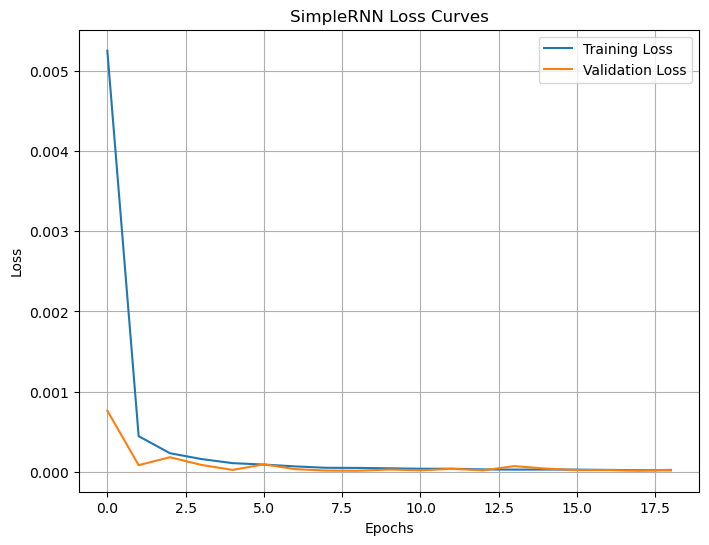

In [ ]:
plot_loss_curves(best_rnn_model.history, title="SimpleRNN Loss Curves")

### GRU

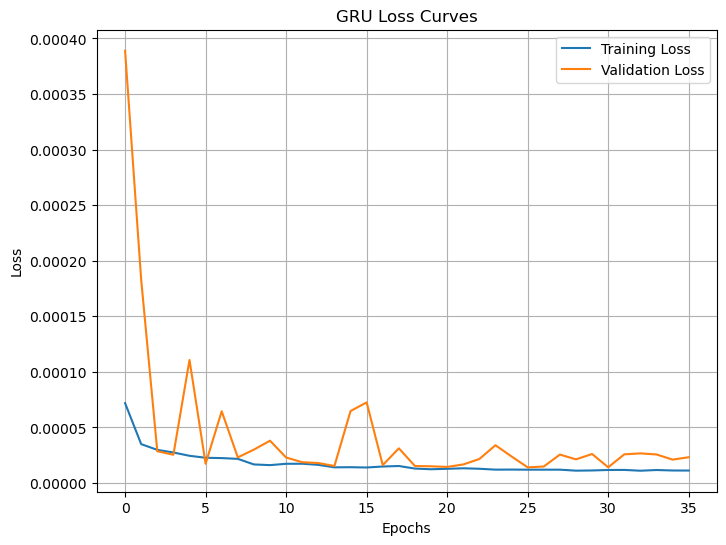

In [ ]:
plot_loss_curves(best_gru_model.history, title="GRU Loss Curves")

### LSTM

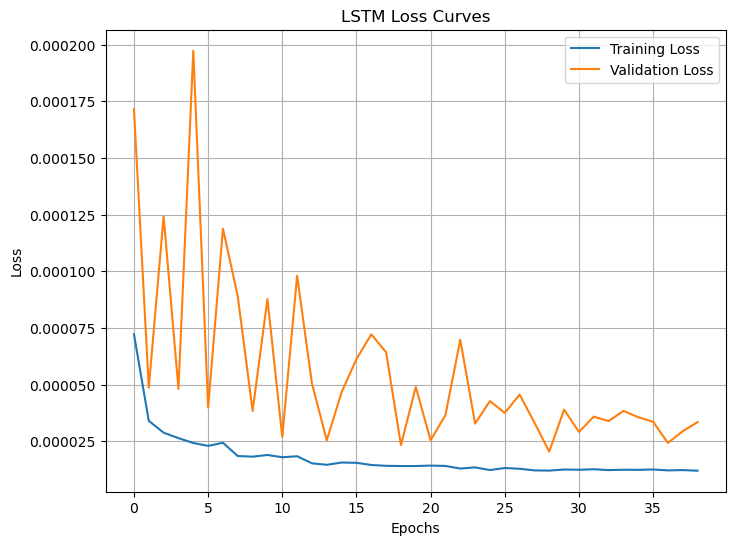

In [ ]:
plot_loss_curves(best_lstm_model.history, title="LSTM Loss Curves")

## Evaluation on Test set

In [ ]:
# Use this function to evaluate the models
rnn_acc, rnn_rmse, rnn_mda, rnn_mae = evaluate_model(best_rnn_model, X_test, y_test)
gru_acc, gru_rmse, gru_mda, gru_mae = evaluate_model(best_gru_model, X_test, y_test)
lstm_acc, lstm_rmse, lstm_mda, lstm_mae = evaluate_model(best_lstm_model, X_test, y_test)

# Print out evaluation results
print(f"SimpleRNN - MDA: {rnn_mda}, Accuracy: {rnn_acc}, RMSE: {rnn_rmse}, MAE: {rnn_mae}")
print(f"GRU - MDA: {gru_mda}, Accuracy: {gru_acc}, RMSE: {gru_rmse}, MAE: {gru_mae}")
print(f"LSTM - MDA: {lstm_mda}, Accuracy: {lstm_acc}, RMSE: {lstm_rmse}, MAE: {lstm_mae}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
SimpleRNN - MDA: 0.49874037504196167, Accuracy: 78.97027648689472, RMSE: 0.17631248469962654, MAE: 0.1309425422157699
GRU - MDA: 0.4987523853778839, Accuracy: 78.6791513863567, RMSE: 0.17815879820837147, MAE: 0.13232051152694854
LSTM - MDA: 0.4987844228744507, Accuracy: 79.07572547557479, RMSE: 0.17587505619811986, MAE: 0.13077742925789487


## Plotting Predictions for Visualization

In [ ]:
# Function to plot predictions against actual values
def plot_predictions(model, X, y, title="Predicted vs Actual Stock Prices"):
    predictions = model.predict(X)
    plt.figure(figsize=(12, 6))
    plt.plot(y, label='Actual', color='blue')
    plt.plot(predictions, label='Predicted', color='orange')
    plt.title(title)
    plt.xlabel('Time Steps')
    plt.ylabel('Stock Prices (Scaled)')
    plt.legend()
    plt.grid()
    plt.show()


### Predictions for Vanilla RNN

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


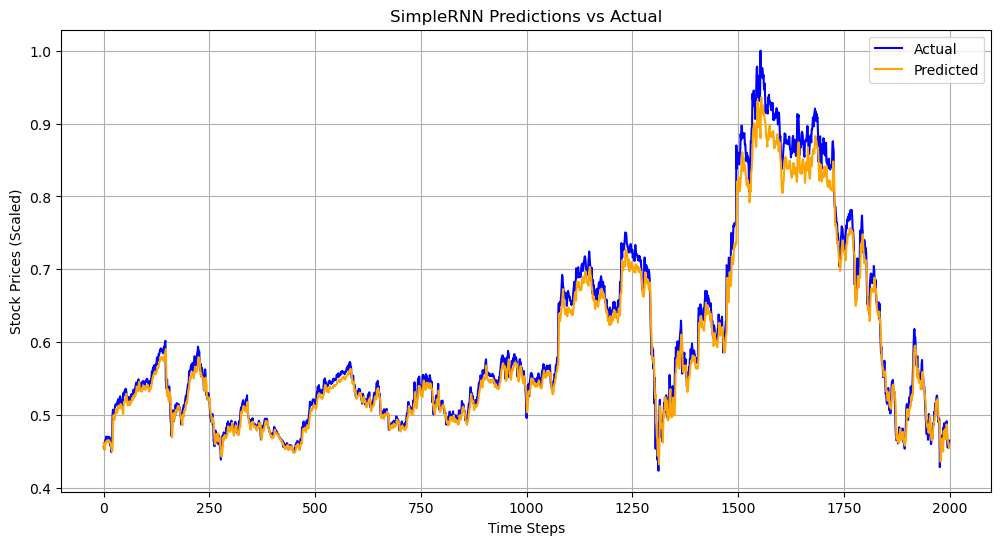

In [ ]:
# Plot predictions for SimpleRNN
plot_predictions(best_rnn_model, X_test, y_test, title="SimpleRNN Predictions vs Actual")

### Predictions for GRU

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


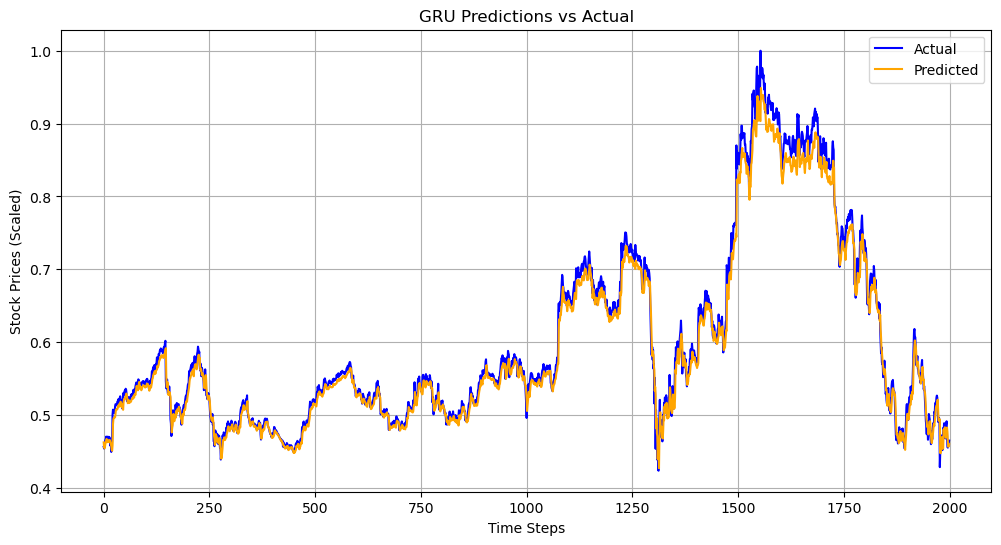

In [ ]:
# Plot predictions for GRU
plot_predictions(best_gru_model, X_test, y_test, title="GRU Predictions vs Actual")

### Predictions for LSTM

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


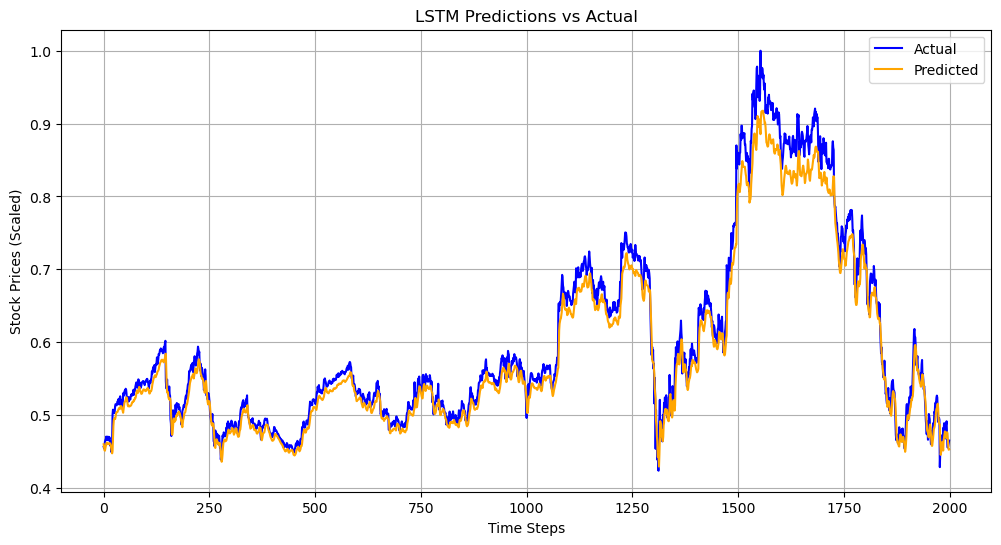

In [ ]:
# Plot predictions for LSTM
plot_predictions(best_lstm_model, X_test, y_test, title="LSTM Predictions vs Actual")

Orange Line (Predicted): Represents the model's predictions for the test data.

Blue Line (Actual): Represents the true stock prices (scaled) for the test data.

Interpretation:
If the orange line closely follows the blue line, the model captures the trend well.
Deviations highlight areas where the model struggles.

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


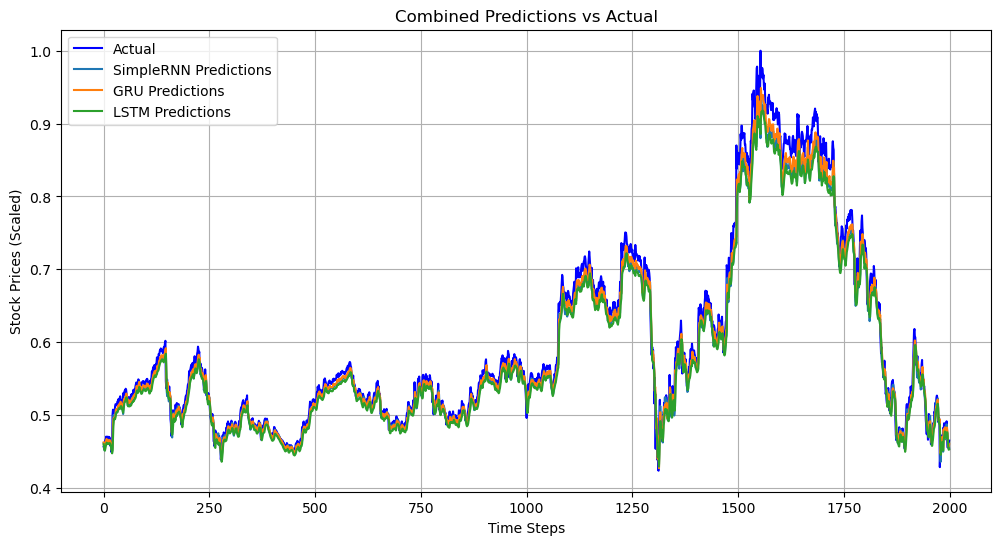

In [ ]:
# Plotting combined predictions
def plot_combined_predictions(models, model_names, X_test, y_test):
    plt.figure(figsize=(12, 6))
    plt.plot(y_test, label='Actual', color='blue')
    for model, name in zip(models, model_names):
        predictions = model.predict(X_test)
        plt.plot(predictions, label=f'{name} Predictions')
    plt.title('Combined Predictions vs Actual')
    plt.xlabel('Time Steps')
    plt.ylabel('Stock Prices (Scaled)')
    plt.legend()
    plt.grid()
    plt.show()

# Plotting predictions for all models
plot_combined_predictions(
    [best_rnn_model, best_gru_model, best_lstm_model],
    ['SimpleRNN', 'GRU', 'LSTM'],
    X_test, y_test
)

## Comparison of Results

In [ ]:
models = ['SimpleRNN', 'GRU', 'LSTM']
mda_values = [rnn_mda, gru_mda, lstm_mda]
acc_values = [rnn_acc, gru_acc, lstm_acc]
rmse_values = [rnn_rmse, gru_rmse, lstm_rmse]
mae_values = [rnn_mae, gru_mae, lstm_mae]

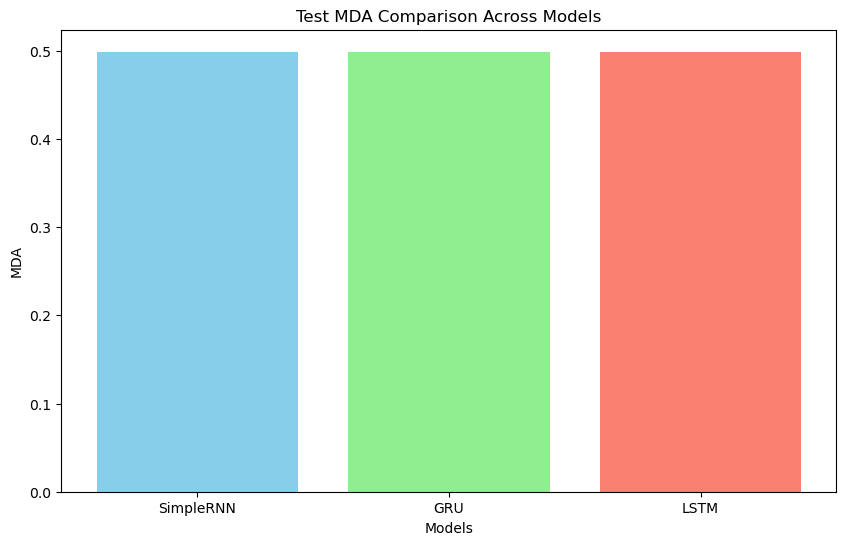

In [ ]:
# Plotting the Bar Chart for MDA
plt.figure(figsize=(10, 6))
plt.bar(models, mda_values, color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Test MDA Comparison Across Models')
plt.xlabel('Models')
plt.ylabel('MDA')
plt.show()

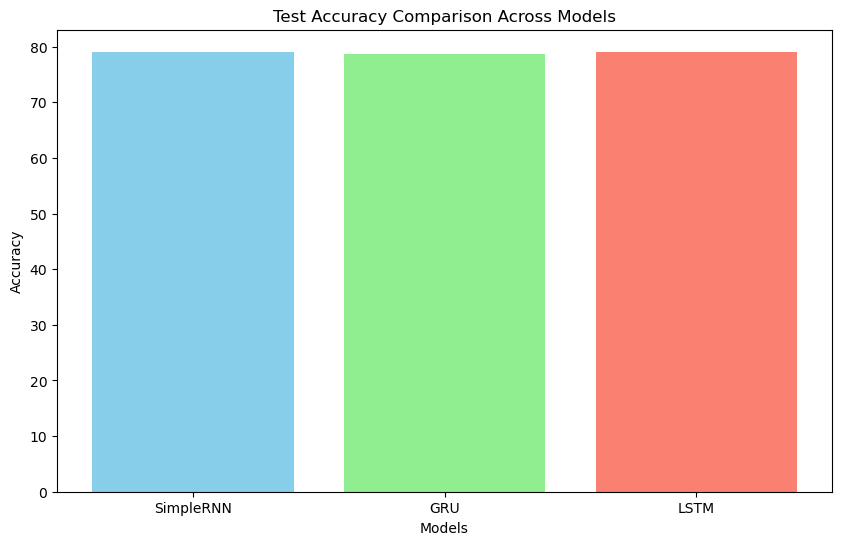

In [ ]:
# Plotting the Bar Chart for Accuracy
plt.figure(figsize=(10, 6))
plt.bar(models, acc_values, color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Test Accuracy Comparison Across Models')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.show()

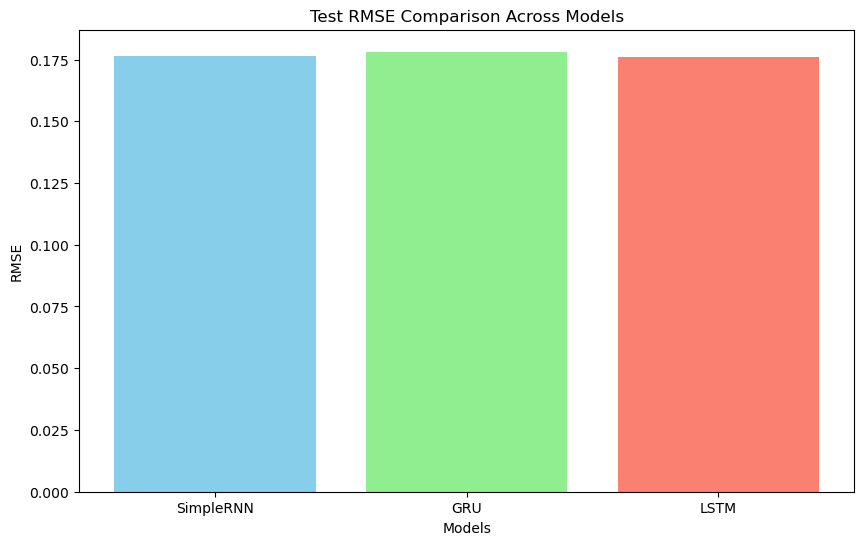

In [ ]:
# Plotting the Bar Chart for RMSE
plt.figure(figsize=(10, 6))
plt.bar(models, rmse_values, color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Test RMSE Comparison Across Models')
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.show()


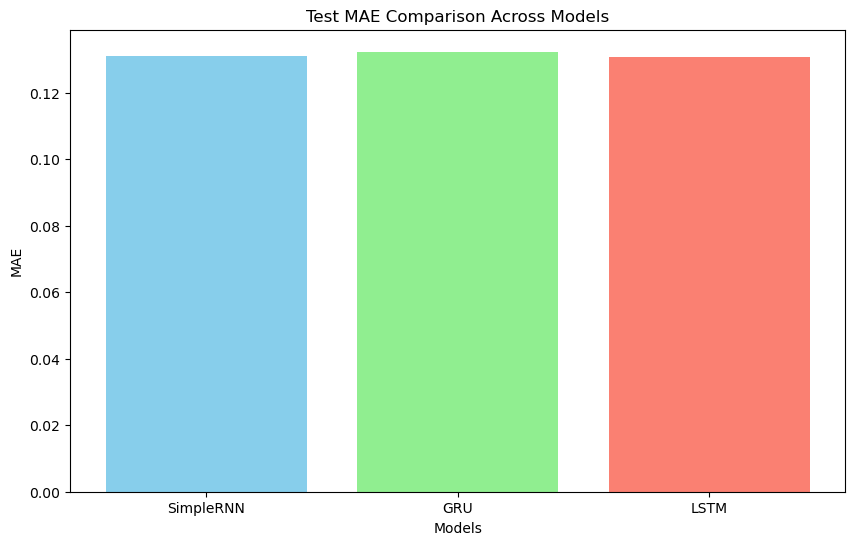

In [ ]:
# Plotting the Bar Chart for MAE
plt.figure(figsize=(10, 6))
plt.bar(models, mae_values, color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Test MAE Comparison Across Models')
plt.xlabel('Models')
plt.ylabel('MAE')
plt.show()

In [ ]:
# Convert tensors to numpy values before creating the DataFrame
rmse_values = [rnn_rmse.numpy(), gru_rmse.numpy(), lstm_rmse.numpy()]  # Convert RMSE tensors
mda_values = [rnn_mda.numpy(), gru_mda.numpy(), lstm_mda.numpy()]  # Convert MDA tensors
acc_values = [rnn_acc, gru_acc, lstm_acc]  # Already numeric
mae_values = [rnn_mae, gru_mae, lstm_mae]  # Already numeric

# Creating a DataFrame to show a comparison table of metrics
metrics_df = pd.DataFrame({
    'Model': models,
    'Accuracy': acc_values,
    'RMSE': rmse_values,
    'MDA': mda_values,
    'MAE': mae_values
})

# Displaying the table of metrics
print("Model Evaluation Comparison:")
print(metrics_df)

# Optionally display the DataFrame for Jupyter Notebook environments
import IPython.display as display
display.display(metrics_df)


Model Evaluation Comparison:
       Model   Accuracy      RMSE       MDA       MAE
0  SimpleRNN  78.970276  0.176312  0.498740  0.130943
1        GRU  78.679151  0.178159  0.498752  0.132321
2       LSTM  79.075725  0.175875  0.498784  0.130777


,Model,Accuracy,RMSE,MDA,MAE
0,SimpleRNN,78.970276,0.176312,0.498740,0.130943
1,GRU,78.679151,0.178159,0.498752,0.132321
2,LSTM,79.075725,0.175875,0.498784,0.130777


### Evaluation of Results

From the `Model Evaluation Comparison` table:

| Model      | Accuracy  | RMSE    | MDA     | MAE     |
|------------|-----------|---------|---------|---------|
| SimpleRNN  | 78.970276 | 0.176312 | 0.498740 | 0.130943 |
| GRU        | 78.679151 | 0.178159 | 0.498752 | 0.132321 |
| LSTM       | 79.075725 | 0.175875 | 0.498784 | 0.130777 |

### Best Model: **LSTM**

#### Reasoning:

1. **Accuracy**:
   - LSTM achieves the highest accuracy (79.08%), which indicates that it performs better than both GRU (78.68%) and SimpleRNN (78.97%) in predicting the direction of stock price changes. This metric is crucial for trading strategies where predicting the trend correctly is vital.

2. **RMSE (Root Mean Squared Error)**:
   - LSTM has the lowest RMSE (0.175875), showing it is the most accurate in terms of minimizing large prediction errors compared to GRU (0.178159) and SimpleRNN (0.176312). This is critical in financial contexts, as large errors can result in significant financial losses.

3. **MDA (Mean Directional Accuracy)**:
   - LSTM slightly outperforms the other models in MDA (0.498784), which measures how well the model predicts the direction (up or down). While the difference is minor, LSTM's higher MDA indicates a better ability to capture stock price trends compared to SimpleRNN (0.498740) and GRU (0.498752).

4. **MAE (Mean Absolute Error)**:
   - LSTM achieves the lowest MAE (0.130777), meaning it has the smallest average prediction error in absolute terms compared to GRU (0.132321) and SimpleRNN (0.130943). This shows LSTM's consistent accuracy in making small, precise predictions.

### Conclusion:

- **LSTM performs the best** because it achieves the **highest accuracy**, **lowest RMSE**, **lowest MAE**, and slightly better **MDA** compared to the other models. These metrics together show that LSTM is the most robust model for both accurate stock price predictions and trend predictions, making it the most suitable for the given task of predicting future stock prices.

- **Reason for Better Performance of LSTM**:
   - LSTMs are designed to handle long-term dependencies better, which is critical in time-series data like stock prices. They retain information over longer sequences, making them well-suited for this task compared to GRU and SimpleRNN. This aligns with the task requirement of predicting future stock prices based on past sequences.